# Udacity Data Science Nanodegree
# Project 2: Software Engineering - Creating a webapp

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing data](#assess)
- [Step 3: Cleaning](#cleaning)
- [Step 4: Storing Data](#storing)
- [Step 5: Analysing and Visualization](#visuals)
- [References](#references)
- [Submission](#submission)

In [1]:
import json
import os
import time
# from io import BytesIO

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.arima_process import arma_generate_sample

import matplotlib as mpl
from pandas.plotting import lag_plot

In [2]:
# file path settings

# general data directory
filename_general = 'data'

# API json data saved as csv
file_marketstack_raw = 'data/marketstack_raw.csv'
file_marketstack_clean = 'data/marketstack_clean.csv'

In [3]:
def create_folder(folder_name):
    """ Make directory if it doesn't already exist """
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name) 
        print('Folder {} created'.format(folder_name))
    else:
        print('Folder {} already exist'.format(folder_name))


def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
   print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis- Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis- Time Series is Non-Stationary')
      
      
def change_ticker(ax):

    # change axis to YYYYMM
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    ax.tick_params(rotation=90, axis='x') 

<a id='datagathering'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Data Gathering</span>


In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

<span style="color:blue">1.1 Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)</span>

In [4]:
# Make main data directory if it doesn't already exist
create_folder(filename_general)

Folder ../data already exist


In [7]:
# import API credentials from environment variables
access_key = os.environ.get('MARKET_STACK_API')

In [96]:
error_list = []

df_all = pd.DataFrame()

# extract API data for stocks of interest  
# stocks = ['GT', 'FTSE.INDX', 'FTAS.INDX', 'AAPL', 'DOW', 'NDAQ', 'DAX', 'MSFT']
stocks = ['GT']
   
for stock in stocks:
    params = {
        'access_key': access_key,
        'symbols': stock,
        'date_from': '2014-01-01',
        'date_to': '2024-02-29',
        'limit': 10000
    }
    
    api_result = requests.get('https://api.marketstack.com/v1/eod', params)
    api_response = api_result.json()
    if api_result.status_code == 200:
        data = api_response['data']
        df = pd.DataFrame.from_dict(data)
        if df_all.shape[0] == 0:
            df_all = df.copy(deep=True)
        else:
            frames = [df, df_all]
            df_all = pd.concat(frames)
            print('#records for {} is {}; total records is {}'.format(stock, df.shape[0], df_all.shape[0]))
    else:
        # construct error message and append to error list
        error_message = "{} Request returned an error: {} {}".format(stock, api_response['error']['code'], api_response['error']['message'])
        print(error_message)
        error_list.append(error_message)   


In [13]:
# get stock name
params = {
    'access_key': access_key,
}

url = 'https://api.marketstack.com/v1/tickers/' + 'GT'
api_result = requests.get(url, params)
api_response = api_result.json()
api_response['name']

'Goodyear Tire & Rubber Company'

In [98]:
df_all.reset_index(drop=True)
df_all.head()

open   high     low  close     volume  adj_high  adj_low  adj_close  \
0  11.90  12.03  11.825  11.88  3257771.0     12.03   11.825      11.88   
1  11.76  12.00  11.720  11.80  3516953.0     12.00   11.720      11.80   
2  11.98  12.03  11.740  11.88  3806990.0     12.03   11.740      11.88   
3  12.19  12.24  11.710  11.81  5186719.0     12.24   11.710      11.81   
4  12.40  12.45  12.210  12.22  2370388.0     12.45   12.210      12.22   

   adj_open  adj_volume  split_factor  dividend symbol exchange  \
0     11.90   3257771.0           1.0       0.0     GT     XNAS   
1     11.76   3516953.0           1.0       0.0     GT     XNAS   
2     11.98   3806990.0           1.0       0.0     GT     XNAS   
3     12.19   5186719.0           1.0       0.0     GT     XNAS   
4     12.40   2370388.0           1.0       0.0     GT     XNAS   

                       date  
0  2024-02-29T00:00:00+0000  
1  2024-02-28T00:00:00+0000  
2  2024-02-27T00:00:00+0000  
3  2024-02-26T00:00:00+0000  
4  2024-02-23T00:00:00+0000

In [99]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          2505 non-null   float64
 1   high          2505 non-null   float64
 2   low           2505 non-null   float64
 3   close         2505 non-null   float64
 4   volume        2505 non-null   float64
 5   adj_high      2119 non-null   float64
 6   adj_low       2119 non-null   float64
 7   adj_close     2505 non-null   float64
 8   adj_open      2119 non-null   float64
 9   adj_volume    2119 non-null   float64
 10  split_factor  2505 non-null   float64
 11  dividend      2505 non-null   float64
 12  symbol        2505 non-null   object 
 13  exchange      2505 non-null   object 
 14  date          2505 non-null   object 
dtypes: float64(12), object(3)
memory usage: 293.7+ KB


In [100]:
# write data to csv
df_all.to_csv(file_marketstack_raw, index=False)

<a id='assess'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Assessing Data</span>


In [101]:
# read twitter_archive table and do visual assessment of a sample
marketstack = pd.read_csv(file_marketstack_raw)
marketstack.head()

open   high     low  close     volume  adj_high  adj_low  adj_close  \
0  11.90  12.03  11.825  11.88  3257771.0     12.03   11.825      11.88   
1  11.76  12.00  11.720  11.80  3516953.0     12.00   11.720      11.80   
2  11.98  12.03  11.740  11.88  3806990.0     12.03   11.740      11.88   
3  12.19  12.24  11.710  11.81  5186719.0     12.24   11.710      11.81   
4  12.40  12.45  12.210  12.22  2370388.0     12.45   12.210      12.22   

   adj_open  adj_volume  split_factor  dividend symbol exchange  \
0     11.90   3257771.0           1.0       0.0     GT     XNAS   
1     11.76   3516953.0           1.0       0.0     GT     XNAS   
2     11.98   3806990.0           1.0       0.0     GT     XNAS   
3     12.19   5186719.0           1.0       0.0     GT     XNAS   
4     12.40   2370388.0           1.0       0.0     GT     XNAS   

                       date  
0  2024-02-29T00:00:00+0000  
1  2024-02-28T00:00:00+0000  
2  2024-02-27T00:00:00+0000  
3  2024-02-26T00:00:00+0000  
4  2024-02-23T00:00:00+0000

In [102]:
marketstack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          2505 non-null   float64
 1   high          2505 non-null   float64
 2   low           2505 non-null   float64
 3   close         2505 non-null   float64
 4   volume        2505 non-null   float64
 5   adj_high      2119 non-null   float64
 6   adj_low       2119 non-null   float64
 7   adj_close     2505 non-null   float64
 8   adj_open      2119 non-null   float64
 9   adj_volume    2119 non-null   float64
 10  split_factor  2505 non-null   float64
 11  dividend      2505 non-null   float64
 12  symbol        2505 non-null   object 
 13  exchange      2505 non-null   object 
 14  date          2505 non-null   object 
dtypes: float64(12), object(3)
memory usage: 293.7+ KB


<a id='cleaning'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Cleaning Data</span>

During assessment step, the following cleaning steps were identified:

1. Convert date to datetime format
2. Select only columns needed for the analysis
3. Set date as index for time series analysis

In [112]:
marketstack_clean = marketstack.copy(deep=True)
marketstack_clean.head()

open   high     low  close     volume  adj_high  adj_low  adj_close  \
0  11.90  12.03  11.825  11.88  3257771.0     12.03   11.825      11.88   
1  11.76  12.00  11.720  11.80  3516953.0     12.00   11.720      11.80   
2  11.98  12.03  11.740  11.88  3806990.0     12.03   11.740      11.88   
3  12.19  12.24  11.710  11.81  5186719.0     12.24   11.710      11.81   
4  12.40  12.45  12.210  12.22  2370388.0     12.45   12.210      12.22   

   adj_open  adj_volume  split_factor  dividend symbol exchange  \
0     11.90   3257771.0           1.0       0.0     GT     XNAS   
1     11.76   3516953.0           1.0       0.0     GT     XNAS   
2     11.98   3806990.0           1.0       0.0     GT     XNAS   
3     12.19   5186719.0           1.0       0.0     GT     XNAS   
4     12.40   2370388.0           1.0       0.0     GT     XNAS   

                       date  
0  2024-02-29T00:00:00+0000  
1  2024-02-28T00:00:00+0000  
2  2024-02-27T00:00:00+0000  
3  2024-02-26T00:00:00+0000  
4  2024-02-23T00:00:00+0000

#### Convert date to datetime format

In [115]:
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'])
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'], format='%Y/%m/%d', errors='raise').dt.date.astype('datetime64[ns]')

marketstack_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   open          2505 non-null   float64       
 1   high          2505 non-null   float64       
 2   low           2505 non-null   float64       
 3   close         2505 non-null   float64       
 4   volume        2505 non-null   float64       
 5   adj_high      2119 non-null   float64       
 6   adj_low       2119 non-null   float64       
 7   adj_close     2505 non-null   float64       
 8   adj_open      2119 non-null   float64       
 9   adj_volume    2119 non-null   float64       
 10  split_factor  2505 non-null   float64       
 11  dividend      2505 non-null   float64       
 12  symbol        2505 non-null   object        
 13  exchange      2505 non-null   object        
 14  date          2505 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12), obj

In [116]:
marketstack_clean.head()

open   high     low  close     volume  adj_high  adj_low  adj_close  \
0  11.90  12.03  11.825  11.88  3257771.0     12.03   11.825      11.88   
1  11.76  12.00  11.720  11.80  3516953.0     12.00   11.720      11.80   
2  11.98  12.03  11.740  11.88  3806990.0     12.03   11.740      11.88   
3  12.19  12.24  11.710  11.81  5186719.0     12.24   11.710      11.81   
4  12.40  12.45  12.210  12.22  2370388.0     12.45   12.210      12.22   

   adj_open  adj_volume  split_factor  dividend symbol exchange       date  
0     11.90   3257771.0           1.0       0.0     GT     XNAS 2024-02-29  
1     11.76   3516953.0           1.0       0.0     GT     XNAS 2024-02-28  
2     11.98   3806990.0           1.0       0.0     GT     XNAS 2024-02-27  
3     12.19   5186719.0           1.0       0.0     GT     XNAS 2024-02-26  
4     12.40   2370388.0           1.0       0.0     GT     XNAS 2024-02-23

#### Select only columns needed for the analysis

In [106]:
cols = ['date', 'symbol', 'close', 'adj_close', 'volume', 'adj_volume', 'dividend']
marketstack_clean = marketstack_clean[cols]
marketstack_clean.head()

date symbol  close  adj_close     volume  adj_volume  dividend
0 2024-02-29     GT  11.88      11.88  3257771.0   3257771.0       0.0
1 2024-02-28     GT  11.80      11.80  3516953.0   3516953.0       0.0
2 2024-02-27     GT  11.88      11.88  3806990.0   3806990.0       0.0
3 2024-02-26     GT  11.81      11.81  5186719.0   5186719.0       0.0
4 2024-02-23     GT  12.22      12.22  2370388.0   2370388.0       0.0

#### Set date as index for time series analysis

In [107]:
marketstack_clean.set_index('date', inplace=True)


In [108]:
marketstack_clean = marketstack_clean.sort_index()
marketstack_clean.head()

symbol  close  adj_close     volume  adj_volume  dividend
date                                                                
2014-03-19     GT  27.31  24.401249  3881000.0   3881000.0       0.0
2014-03-20     GT  27.24  24.338704  2966200.0   2966200.0       0.0
2014-03-21     GT  26.92  24.052787  3563700.0   3563700.0       0.0
2014-03-24     GT  26.47  23.650716  5708400.0   5708400.0       0.0
2014-03-25     GT  26.13  23.346929  3257500.0   3257500.0       0.0

<a id='storing'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 5: Storing Data</span>

In [109]:
marketstack_clean.to_csv(file_marketstack_clean, index=True)

<a id='visuals'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 6: Analyzing and Visualizing Data</span>

In this section, analyze and visualize wrangled data

In [110]:
# read the cleaned twitter master data from csv
marketstack_clean = pd.read_csv(
    file_marketstack_clean, 
    parse_dates=['date'], 
    index_col=['date'])
marketstack_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2505 entries, 2014-03-19 to 2024-02-29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      2505 non-null   object 
 1   close       2505 non-null   float64
 2   adj_close   2505 non-null   float64
 3   volume      2505 non-null   float64
 4   adj_volume  2119 non-null   float64
 5   dividend    2505 non-null   float64
dtypes: float64(5), object(1)
memory usage: 137.0+ KB


In [126]:
# prepare dataset to compare GY stock with overall stock market NDAQ
marketstack_filtered = marketstack_clean[marketstack_clean['symbol'].isin(['GT'])]
marketstack_filtered = marketstack_filtered[['close', 'dividend', 'volume']]
# marketstack_filtered = marketstack_filtered.pivot(columns='symbol', values=['close', 'dividend'])
marketstack_filtered.columns = ['GT', 'dividend', 'volume']
marketstack_filtered['volume'] = marketstack_filtered['volume']/1000000
marketstack_filtered = marketstack_filtered.rolling(7, center=False).mean()
marketstack_filtered.tail()

GT  dividend  volume
2500  26.13       0.0  3.2575
2501  26.47       0.0  5.7084
2502  26.92       0.0  3.5637
2503  27.24       0.0  2.9662
2504  27.31       0.0  3.8810

## Resampling

In [21]:
# Use resample to monthly to reduce noice
freq = 'MS'
marketstack_monthly = (marketstack_filtered.resample(freq).agg({'GT': 'median', 
                                                               'volume': 'max',
                                                               'dividend': 'sum'})) 

marketstack_monthly.dropna(inplace=True)

marketstack_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-03-01 to 2024-02-01
Freq: MS
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GT        120 non-null    float64
 1   volume    120 non-null    float64
 2   dividend  120 non-null    float64
dtypes: float64(3)
memory usage: 3.8 KB


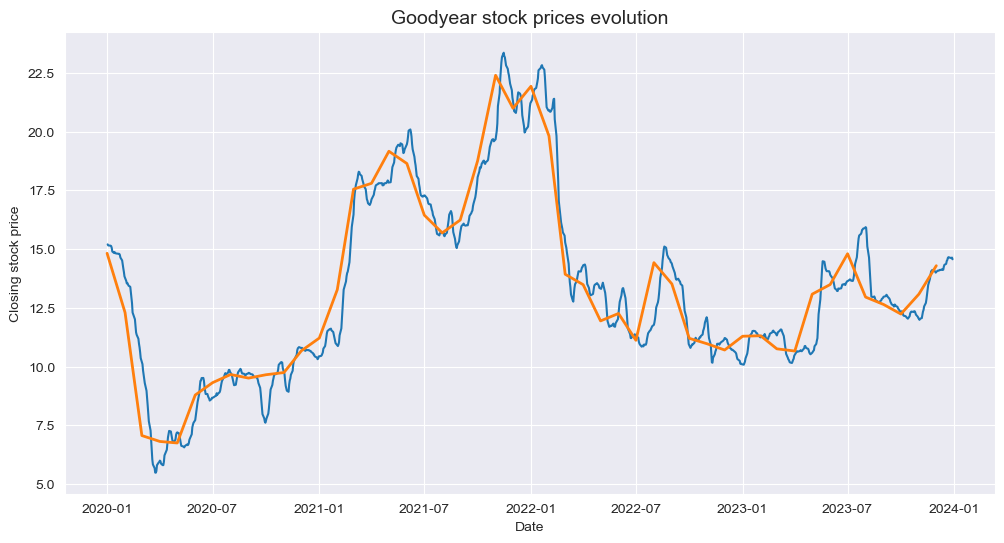

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

sns.lineplot(x="date", 
             y="GT",
             data=marketstack_filtered['2020':'2023'],
             ax=ax,
             )

sns.lineplot(x="date", 
             y="GT",
             data=marketstack_monthly['2020':'2023'],
             lw=2,
             ax=ax,
             )

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear stock prices evolution', fontsize=14)
plt.show()

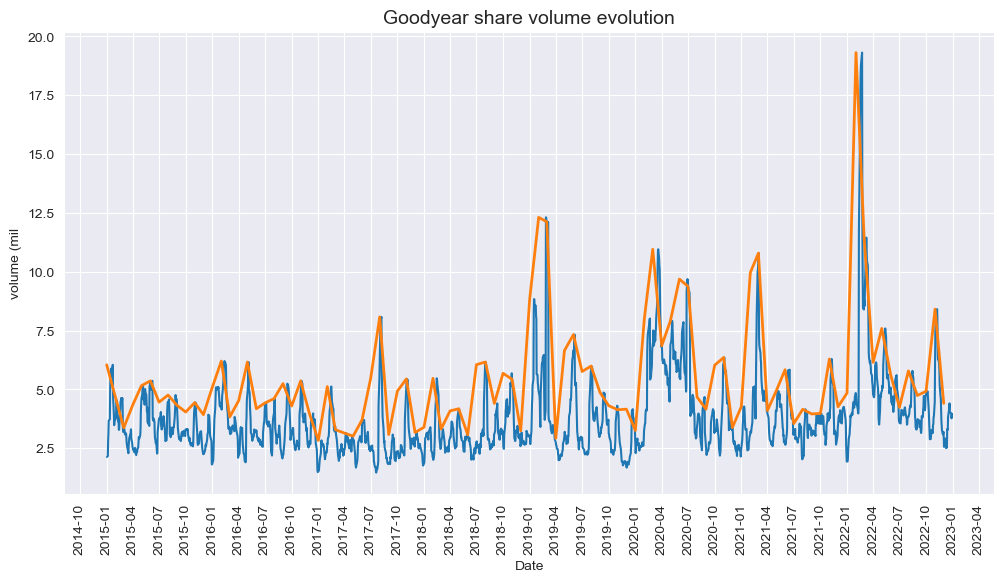

In [23]:
    
fig, ax = plt.subplots(1, 1, figsize=(12,6))

sns.lineplot(x="date", 
             y="volume",
             data=marketstack_filtered['2015-01':'2022-12'],
             ax=ax,
             )

sns.lineplot(x="date", 
             y="volume",
             data=marketstack_monthly['2015-01':'2022-12'],
             lw=2,
             ax=ax,
             )

ax = change_ticker(ax)

plt.ylabel('volume (mil')
plt.xlabel('Date')
plt.title('Goodyear share volume evolution', fontsize=14)
plt.show()

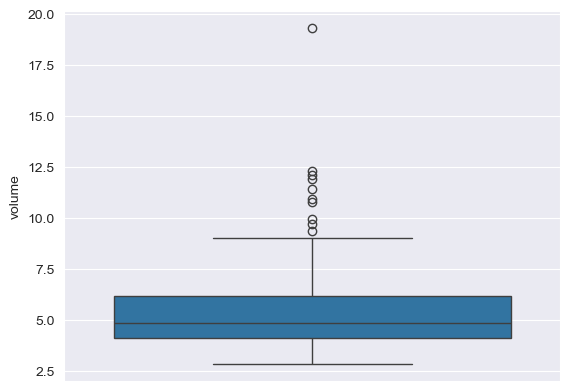

In [24]:
sns.boxplot(marketstack_monthly['volume'])
plt.show()

In [25]:
# to predict share volume, we have to reset the once-off 20 mil peak
marketstack_monthly['volume'].describe([0.25, 0.75, 0.90, 0.99])


count    120.000000
mean       5.553323
std        2.444598
min        2.833510
25%        4.102932
50%        4.856423
75%        6.161126
90%        8.453956
99%       12.274782
max       19.311653
Name: volume, dtype: float64

In [26]:
new_max = marketstack_monthly['volume'].quantile(0.99)
marketstack_monthly['volume'] = np.where(marketstack_monthly['volume'] > new_max, new_max, marketstack_monthly['volume'])

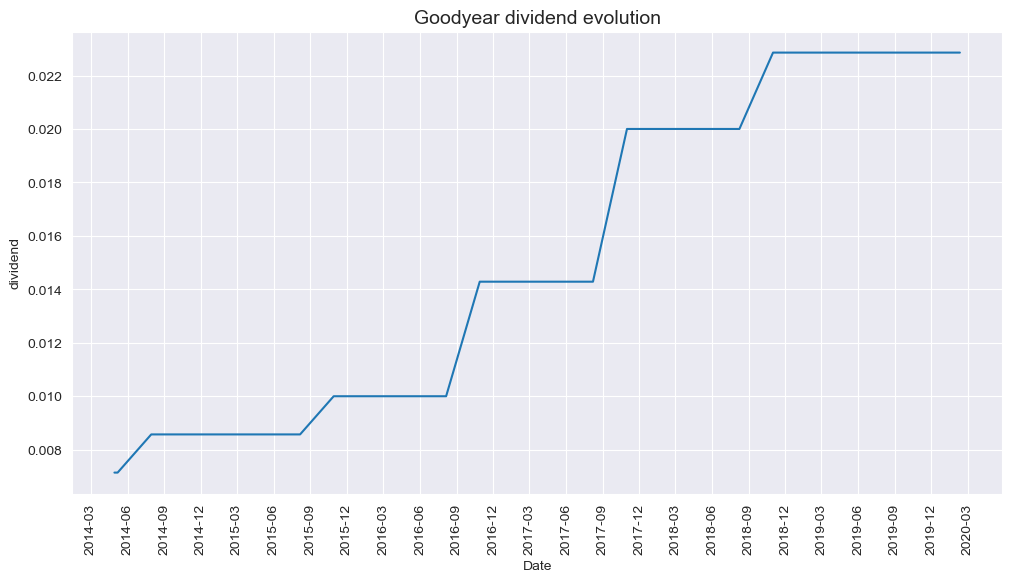

In [27]:
   
fig, ax = plt.subplots(1, 1, figsize=(12,6))

data = marketstack_filtered[marketstack_filtered['dividend'] > 0]

sns.lineplot(x="date", 
             y="dividend",
             data=data,
             ax=ax,
             )

ax = change_ticker(ax)

plt.ylabel('dividend')
plt.xlabel('Date')
plt.title('Goodyear dividend evolution', fontsize=14)
plt.show()

In [28]:
marketstack_monthly.corr()

GT    volume  dividend
GT        1.000000 -0.371432   0.22541
volume   -0.371432  1.000000   0.08091
dividend  0.225410  0.080910   1.00000

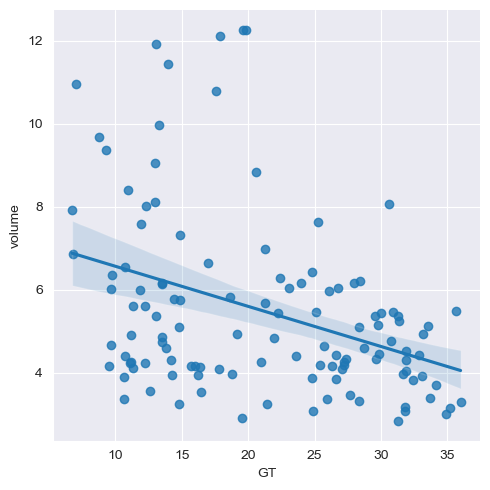

In [29]:
sns.lmplot(data=marketstack_monthly, x='GT', y='volume')
plt.show()

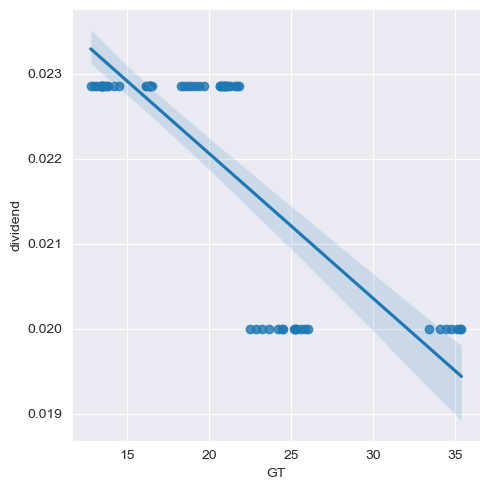

In [30]:
data = marketstack_filtered[marketstack_filtered['dividend'] > 0]
sns.lmplot(data=data['2018':], x='GT', y='dividend')
plt.show()

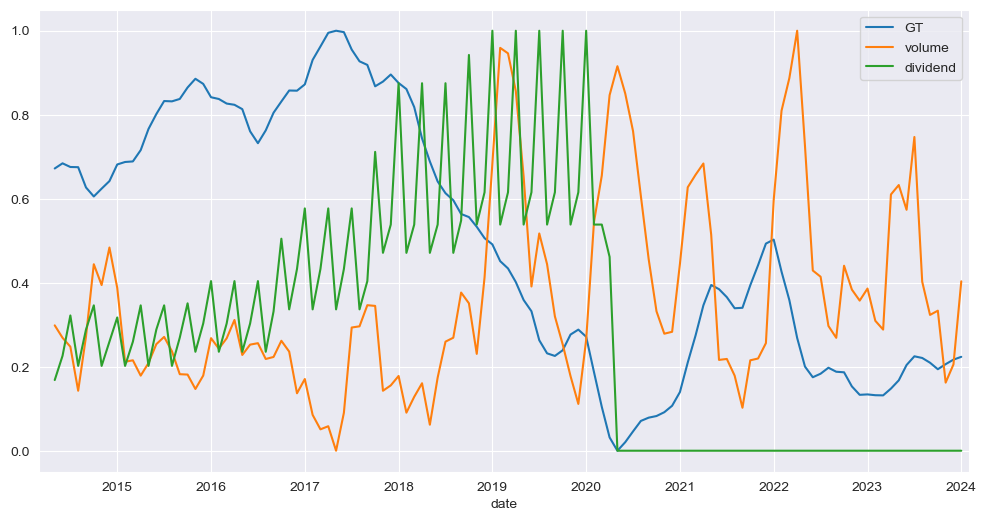

In [31]:
# PLot trends - are there some relationships ?
fig , ax = plt.subplots(figsize=(12,6))
scaler = MinMaxScaler()
data = marketstack_monthly.rolling(4, center=True).mean()
data[:] = scaler.fit_transform(data[:])

data.GT.plot(ax=ax)
data.volume.plot(ax=ax)
data.dividend.plot(ax=ax)
plt.legend()
plt.show()

Conclusion:
- The downward trend of stock price started in 2018 pre covid, and was not due to divident payouts.
- As the shared price decreased, the number of shares increase in period 2018 to 2019, thereafter it looks like volume of shares have a seasonal pattern

>Resampled with aggregate mean gives a smoother cleaner result

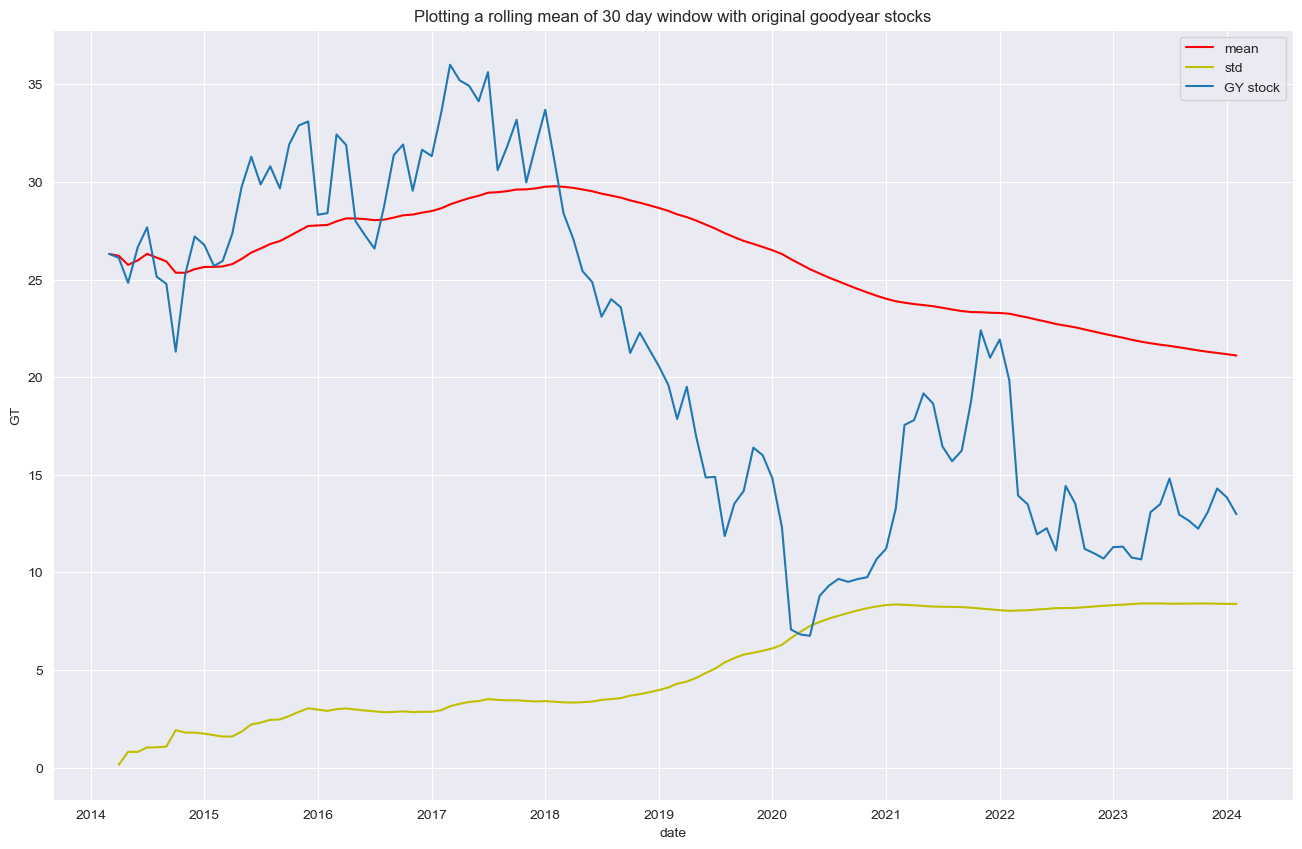

In [32]:
# expanding window functions (like an accumulative mean calculation)
plt.figure(figsize=(16,10))
gy_mean = marketstack_monthly['GT'].expanding().mean()
gy_std = marketstack_monthly['GT'].expanding().std()
sns.lineplot(gy_mean, label='mean', color='r')
sns.lineplot(gy_std, label='std', color='y')
sns.lineplot(marketstack_monthly['GT'], label='GY stock')
plt.legend()
plt.title('Plotting a rolling mean of 30 day window with original goodyear stocks')
plt.show()

> There is a downward trend in mean, and  an upwords trend in std

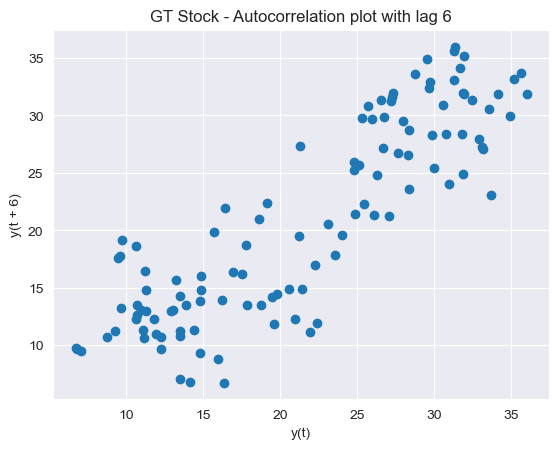

In [33]:
# Before building the ARIMA model, let’s see if there is some cross-correlation in out data.
plt.figure()
lag_plot(marketstack_monthly['GT'], lag=6)
plt.title('GT Stock - Autocorrelation plot with lag 6')
plt.show()

# ARIMA analysis

# Step 1: White noice

White noise has...
- Constant mean
- Constant variance
- No trends
- Zero auto-correlation at all lags, no pattern with past data

Can't Forecast White Noise
A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Today's value, does not depend on yesterday's value, like flipping a coin.

Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

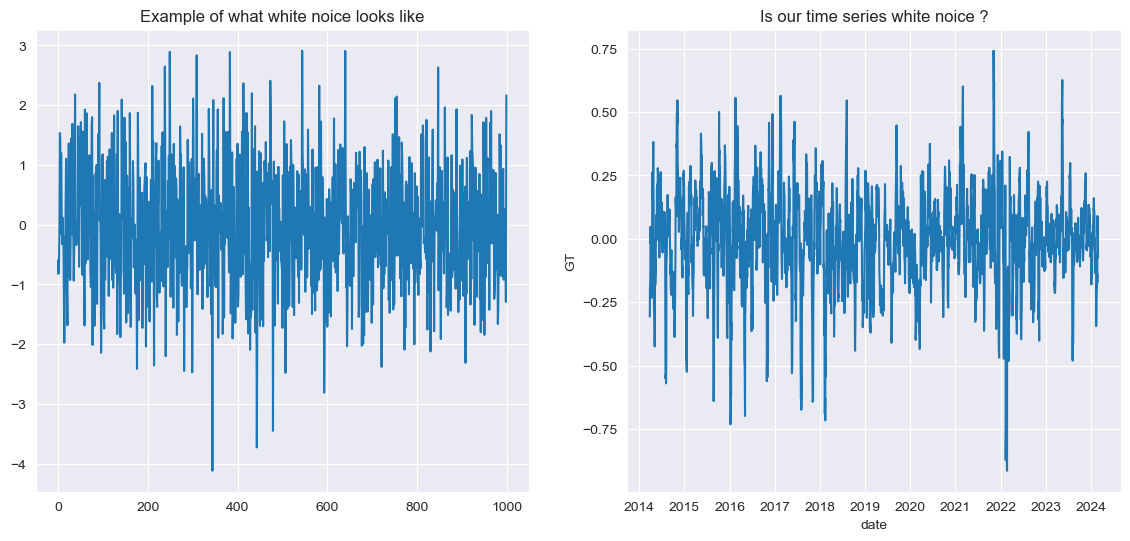

In [34]:
# Plotting white noise - example what it looks like

fig, axes = plt.subplots(1,2, figsize=(14, 6))
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
ax1 = sns.lineplot(white_noise, ax=axes[0])
ax2 = sns.lineplot(marketstack_filtered['GT'].diff(), ax=axes[1])
ax1.set_title('Example of what white noice looks like')
ax2.set_title('Is our time series white noice ?')
plt.show()

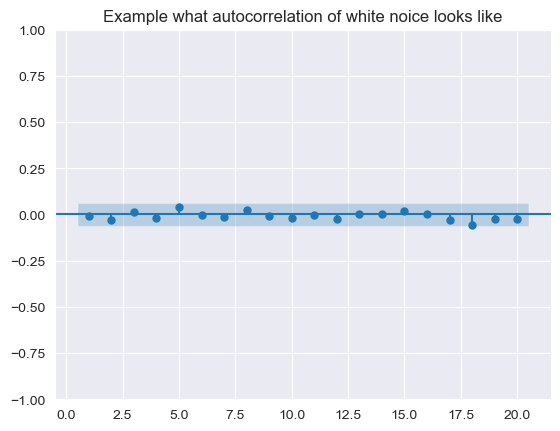

In [35]:
# Plotting autocorrelation of white noise
tsaplots.plot_acf(white_noise,lags=20, zero=False)
plt.title('Example what autocorrelation of white noice looks like')
plt.show()

# Step 2. Stationarity

#### Dickey-Fuller(ADF)  test - Is the time series stationary ?

For the ease of automation, we will be Using Augmented Dickey-Fuller(ADF) Test

Null Hypothesis : Time series is non-stationary due to trend (p_value > 0.05)

Alternate Hypothesis : Time series is stationary (p_value < 0.05)

Time Series is Stationary if we have constant mean, constant variance and No Trend and Seasonality. The data does not change with time.


Dickey-Fuller helps us to see if our time series is a random walk or not. 
If pvalue is < 5% it is not random walk and we can use it for forecasting without any transformations. If pvalue > 5%, we have to convert the time series to make it stationary first, with other .diff() or .pct_change(), however ARIMA works with diff best.

## Random walk with drift

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

Pt = Pt-1 + εt
Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)

Pt - Pt-1 = μ + εt

Regression test for random walk

Pt = α + βPt-1 + εt
Equivalent to Pt - Pt-1 = α + βPt-1 + εt

Test:

H0: β = 1 (This is a random walk)
H1: β < 1 (This is not a random walk)

Dickey-Fuller Test:

H0: β = 0 (This is a random walk)
H1: β < 0 (This is not a random walk)

In a random walk with drift, prices on average drift by mu every period. And the change in price for a random walk with drift is still white noise but with a mean of mu. So if we now think of stock prices as a random walk with drift, then the returns are still white noise, but with an average return of mu instead of zero.

To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk.

**Statistical Test for Random Walk**
An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.

This is called the "Dickey-Fuller" test. If you add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.



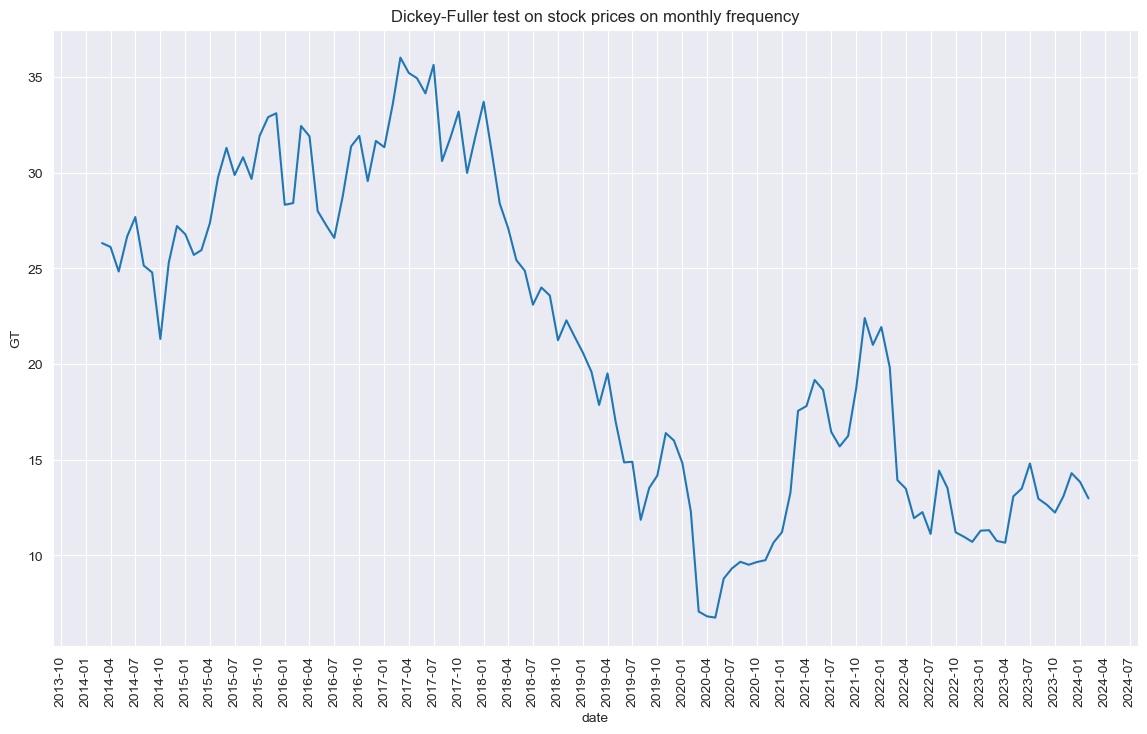


The p-value is: 0.7000167170929936


In [36]:
# Run adfuller test
plt.figure(figsize=(14,8))

ax = sns.lineplot(marketstack_monthly['GT'])

ax = change_ticker(ax)

plt.title('Dickey-Fuller test on stock prices on monthly frequency')
plt.show()

results = adfuller(marketstack_monthly['GT'])
print('\nThe p-value is: ' + str(results[1]))

> GY stock prices without transformation is a random walk with trends as pvalue > 0.05, and cannot be used for forecasting without transformation when using ARIMA.

> If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. This is good news it means we can use the time series to forecast future results

# Step 3: Making a time series stationary

We will use First Order Differencing to detrend the series

If a time series is a random walk, convert it into stationary dataset first before we can do any forecasting when using the ARIMA model.

A less restrictive version of stationarity, and one that is easier to test, is weak stationarity, which just means that the mean, variance, and autocorrelations of the observations do not depend on time. In other words, for the autocorrelation, the correlation between X-t and X-(t-tau) is only a function of the lag tau, and not a function of time.

If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. You may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate.

diff() or pct_change() method can easily convert a non-stationary series to a stationary series.
Sometimes, we might have to take the difference more than once to make it stationary, example .diff().diff()

**Other transformations:**
- np.log(df)
- np.sqrt(df)
- df.shift(1)/df - take proportional change

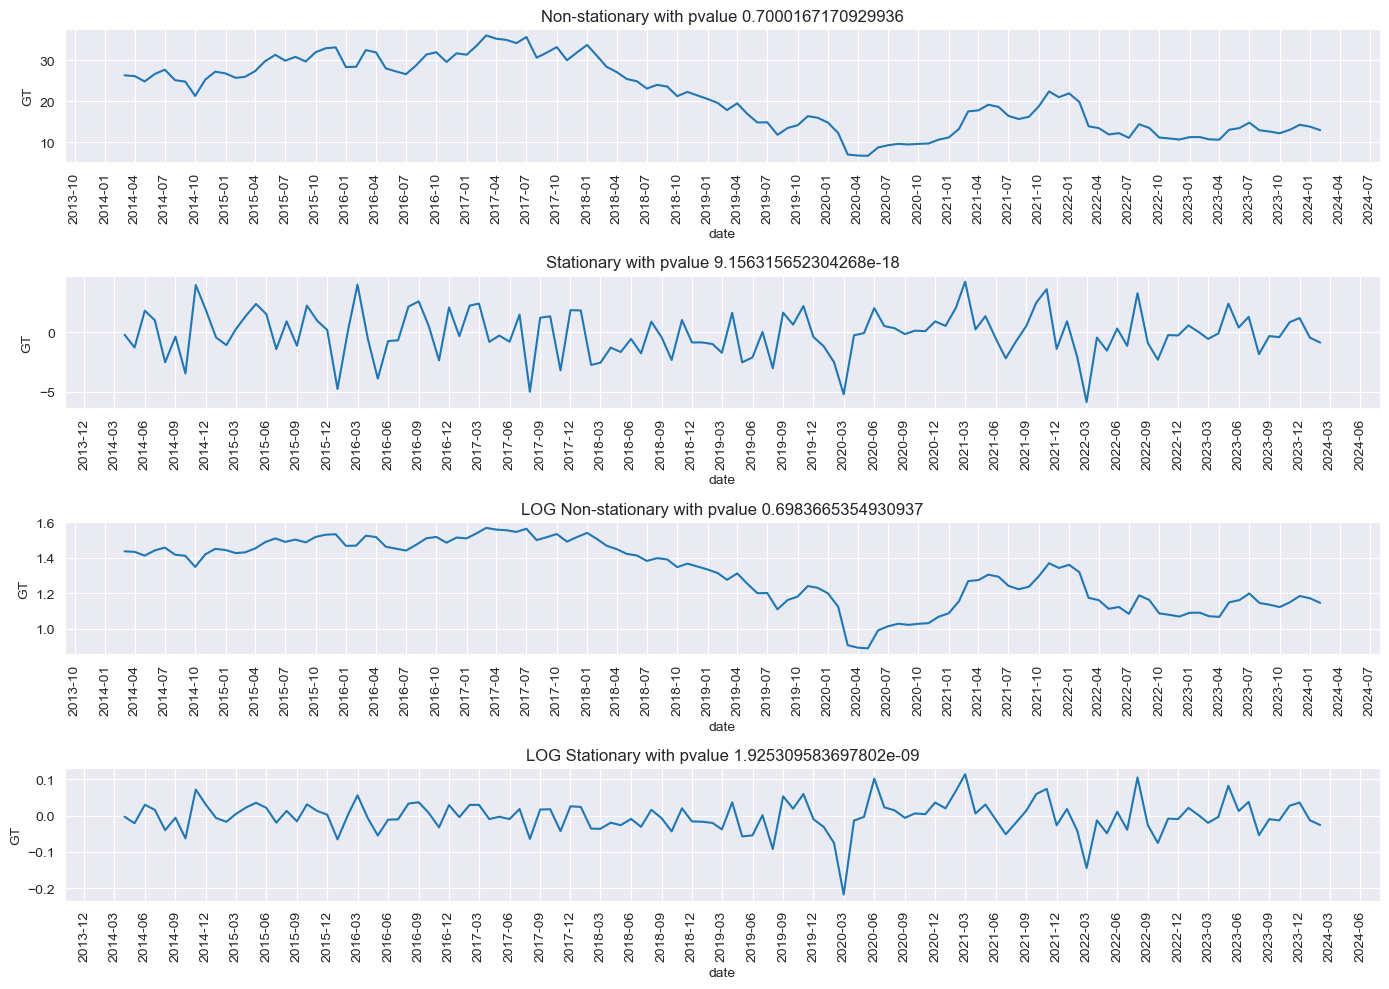

In [37]:
# example on non-stationary plot, time influence the stock prices, example pre and post covid
fig, axes = plt.subplots(4,1, figsize=(14,10))

ax1 = sns.lineplot(data=marketstack_monthly['GT'], ax=axes[0])
results = adfuller(marketstack_monthly['GT'])
ax1.title.set_text('Non-stationary with pvalue {}'.format(results[1]))
ax1 = change_ticker(ax1)

marketstack_diff = marketstack_monthly.diff().dropna()
ax2 = sns.lineplot(marketstack_diff['GT'], ax=axes[1])
results = adfuller(marketstack_diff['GT'])
ax2.title.set_text('Stationary with pvalue {}'.format(results[1]))
ax2 = change_ticker(ax2)

marketstack_log = np.log10(marketstack_monthly + 1)
ax3 = sns.lineplot(marketstack_log['GT'], ax=axes[2])
results = adfuller(marketstack_log['GT'])
ax3.title.set_text('LOG Non-stationary with pvalue {}'.format(results[1]))
ax3 = change_ticker(ax3)

marketstack_logdiff = marketstack_log.diff().dropna()
ax4 = sns.lineplot(marketstack_logdiff['GT'], ax=axes[3])
results = adfuller(marketstack_logdiff['GT'])
ax4.title.set_text('LOG Stationary with pvalue {}'.format(results[1]))
ax4 = change_ticker(ax4)

plt.tight_layout()

>**Important:** Time series is now stationary, however Dickey Fuller only test for non-stationary due to trend. It would not test for remaining **seasonality** patterns.

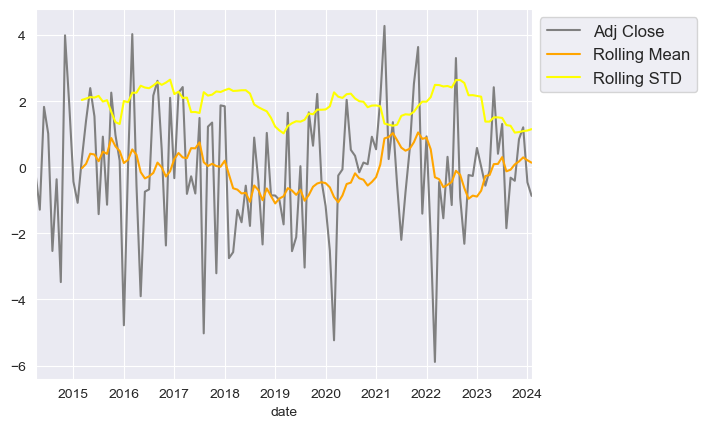

In [38]:
##Differencing By 1
fig, ax = plt.subplots(1,1)
marketstack_diff['GT'].plot(c='grey', ax=ax, label='Adj Close')
marketstack_diff['GT'].rolling(12).mean().plot(label='Rolling Mean',c='orange', ax=ax)
marketstack_diff['GT'].rolling(12).std().plot(label='Rolling STD',c='yellow', ax=ax)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 12})
plt.show()

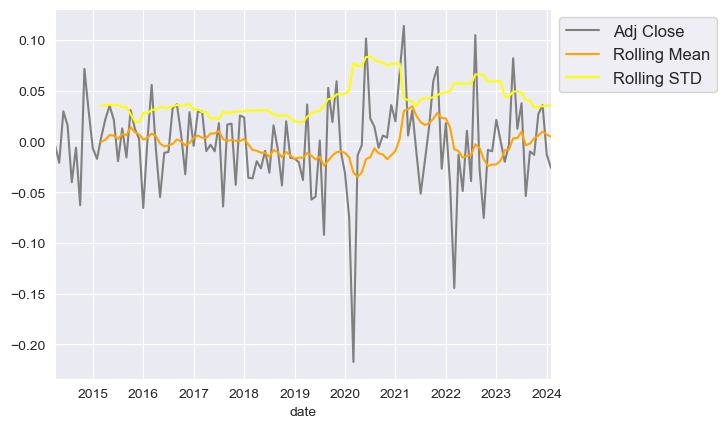

In [39]:
##Differencing By 1
fig, ax = plt.subplots(1,1)
marketstack_logdiff['GT'].plot(c='grey', ax=ax, label='Adj Close')
marketstack_logdiff['GT'].rolling(12).mean().plot(label='Rolling Mean',c='orange', ax=ax)
marketstack_logdiff['GT'].rolling(12).std().plot(label='Rolling STD',c='yellow', ax=ax)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 12})
plt.show()

**Conclusion**:
- Log is not significantly smoothing the time series, and are removing seasonal patterns

# Step 4: Modelling

#### Autoregressive (AR) Models
In an autoregressive model we regress the values of the time series against previous values of this same time series. Similar to linear regression. For example if lag is 12, all values at all 12 lags would contribute to the final forecast.

#### Moving Average (MA) Models
In a moving average model we regress the values of the time series against the previous shock/noice values of this same time series. For example if lag is 12, only the noice value today - 12 months would be looked at.

#### ARIMA model
Combination of AR + MA

Order paramater:
- p: order of AR part
- d: order of differencing (number of times to call .diff() to make time series stationary)
- q: order of MA part

The statsmodels class ARMA has been deprecated and replaced with the slightly more general ARIMA class. After importing ARIMA, create an instance of that class called mod, with the arguments being the data that you're trying to fit, and the order of the model. 

The order (1,0,0) means you're fitting the data to an AR(1) model with only 1 lag. An order (2,0,0) would mean you're fitting the data to an AR(2) model with 2 lags. 

The middle number, d, relates to whether you take first differences of the data to make the time series stationary, like you would do with a random walk. For now, we'll assume there are no first differences so the middle number will be zero.

In the last chapter, we will give an example where we do take first differences. The third number, q, is the MA part, which will be discussed in the next chapter. Once you instantiate the class, you can use the method fit to estimate the model, and store the results in result.

### Train-test split

In [40]:
# split dataset into train and test data
df_train = marketstack_monthly.loc[:'2023-06']
df_test = marketstack_monthly.loc['2023-07':]
df_train.head()

GT    volume  dividend
date                                     
2014-03-01  26.312143  4.174300  0.000000
2014-04-01  26.110000  5.974014  0.014286
2014-05-01  24.827143  6.419400  0.035714
2014-06-01  26.655000  3.839400  0.000000
2014-07-01  27.672143  3.454550  0.017143

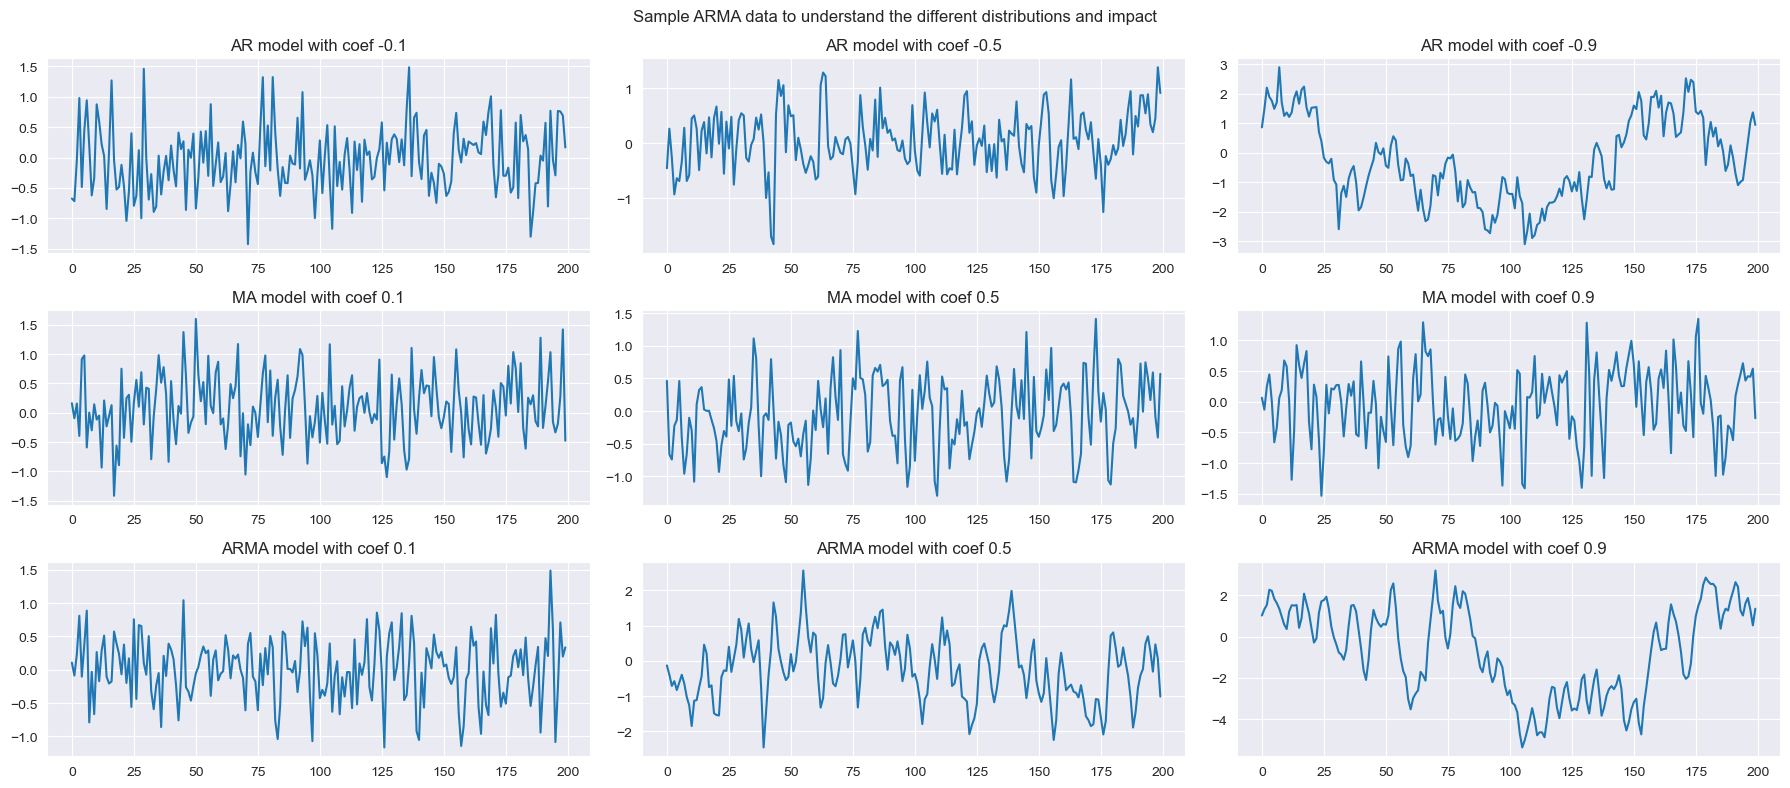

In [41]:
# simulate ARMA data to understand effects of the order parameters
fig, axes = plt.subplots(3,3, figsize=(18,8))
ar_coefs = [1, -0.1]
ma_coefs = [1, 0]
y1 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax1 = sns.lineplot(y1, ax=axes[0,0])
ax1.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, -0.5]
ma_coefs = [1, 0]
y2 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax2 = sns.lineplot(y2, ax=axes[0,1])
ax2.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, -0.9]
ma_coefs = [1, 0]
y3 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax3 = sns.lineplot(y3, ax=axes[0,2])
ax3.set_title('AR model with coef {}'.format(ar_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.1]
y4 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax4 = sns.lineplot(y4, ax=axes[1,0])
ax4.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.5]
y5 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax5 = sns.lineplot(y5, ax=axes[1,1])
ax5.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, 0]
ma_coefs = [1, 0.9]
y6 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax6 = sns.lineplot(y6, ax=axes[1,2])
ax6.set_title('MA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.1]
ma_coefs = [1, 0.1]
y7 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax7 = sns.lineplot(y7, ax=axes[2,0])
ax7.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.5]
ma_coefs = [1, 0.5]
y8 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax8 = sns.lineplot(y8, ax=axes[2,1])
ax8.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

ar_coefs = [1, -0.9]
ma_coefs = [1, 0.9]
y9 = arma_generate_sample(ar_coefs, ma_coefs, nsample=200, scale=0.5)
ax9 = sns.lineplot(y9, ax=axes[2,2])
ax9.set_title('ARMA model with coef {}'.format(ma_coefs[1]))

plt.suptitle('Sample ARMA data to understand the different distributions and impact')
plt.tight_layout()

# Predicting volume

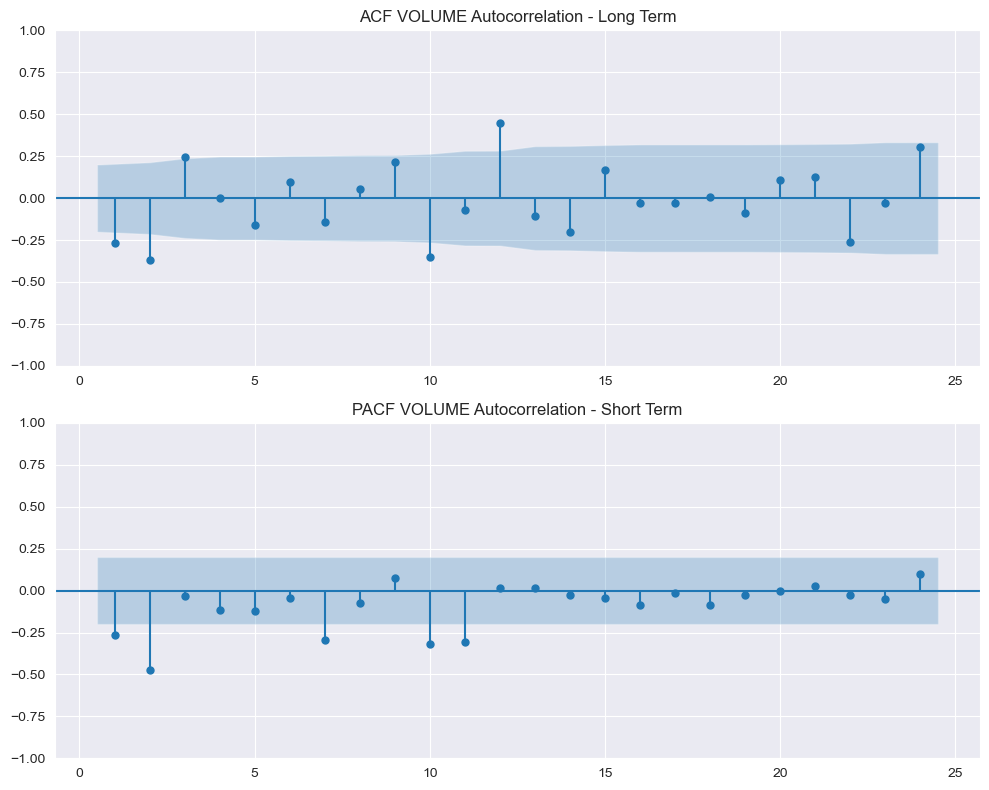

In [42]:
# autocorrelation of volume of shares
marketstack_diff = marketstack_monthly.diff().dropna()

fig, axes = plt.subplots(2,1, figsize=(10,8))

# Plot the ACF
ax1 = tsaplots.plot_acf(marketstack_diff['2016': '2023']['volume'], 
                  lags=24, 
                  zero=False, 
                  # alpha=0.05, 
                  ax=axes[0])
axes[0].title.set_text('ACF VOLUME Autocorrelation - Long Term')

# Plot the PACF
tsaplots.plot_pacf(marketstack_diff['2016': '2023']['volume'], 
                  lags=24, 
                  zero=False, 
                  # alpha=0.05, 
                  ax=axes[1])
axes[1].title.set_text('PACF VOLUME Autocorrelation - Short Term')
plt.tight_layout()

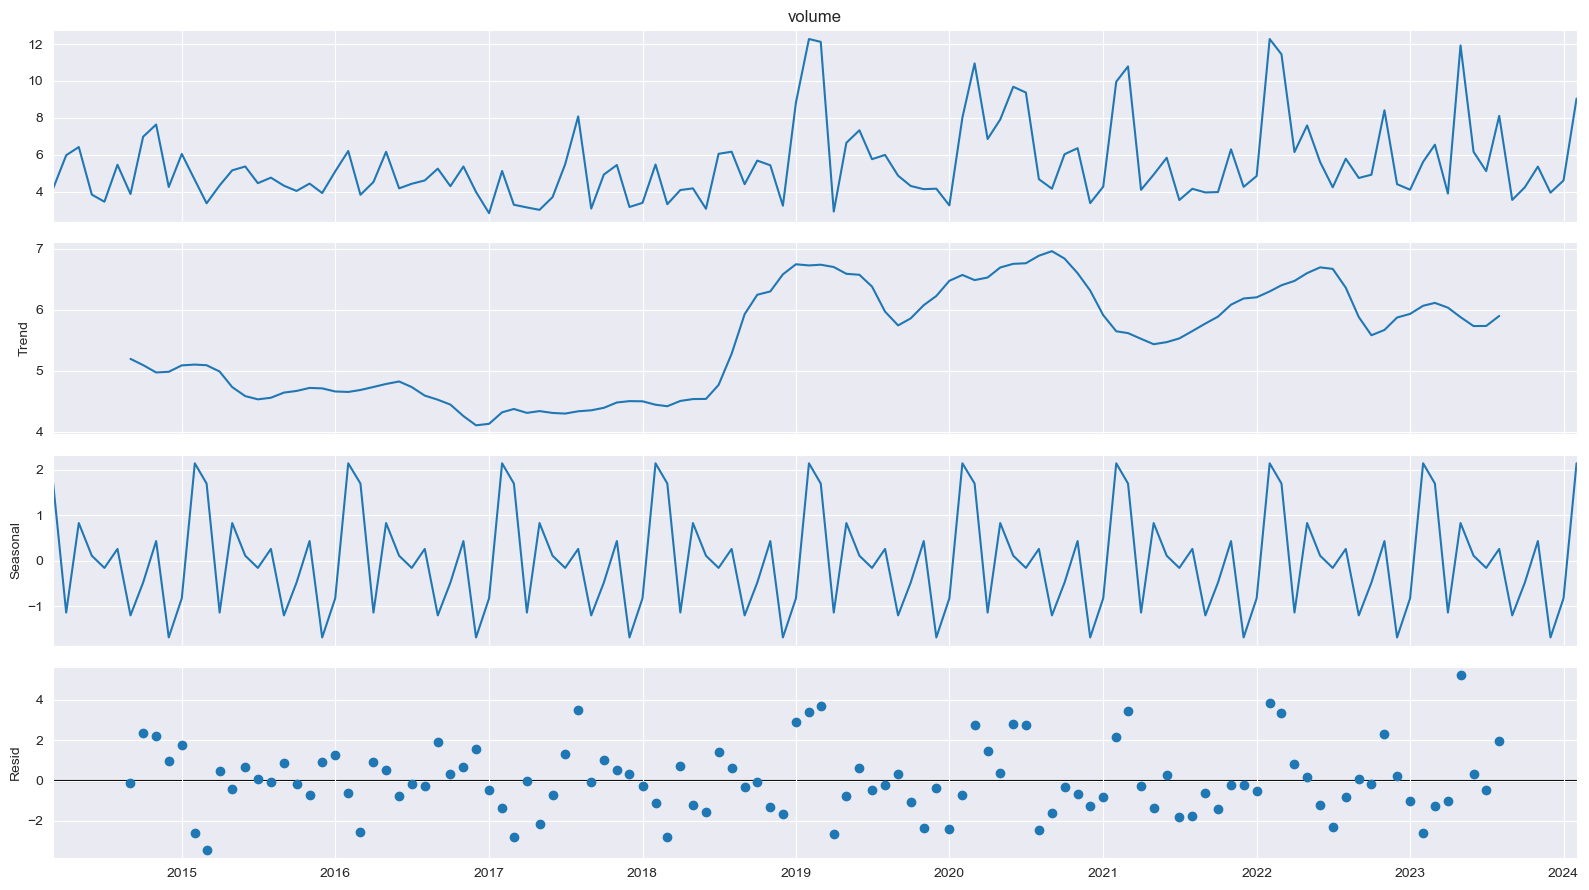

In [43]:
decomposition = seasonal_decompose(
    marketstack_monthly['volume'],
    period=12,
    # extrapolate_trend=12,
)

fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.tight_layout()

In [44]:
# results of best model
auto_arima_results = pm.auto_arima(
    df_train['volume'],
    seasonal=True,
    trace=False,
    # n_jobs=-1,
    D=1,
    d=1,
    # test='adf',
    m=12,
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    max_p=12,
    max_q=12,
    max_P=12,
    max_Q=12,
    max_order=24,
    information_criterion='aic',
    error_action='ignore',
    stepwise=True,
    maxiter=10000,
    # suppress_warnings=True,
    # enforce_stationarity=True,
    # enforce_invertibility=True,    
)

print(auto_arima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  112
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -209.098
Date:                              Mon, 18 Mar 2024   AIC                            426.196
Time:                                      17:54:58   BIC                            436.577
Sample:                                  03-01-2014   HQIC                           430.396
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5331      0.072     -7.443      0.000      -0.673      -0.393
ma.L2         -0.40

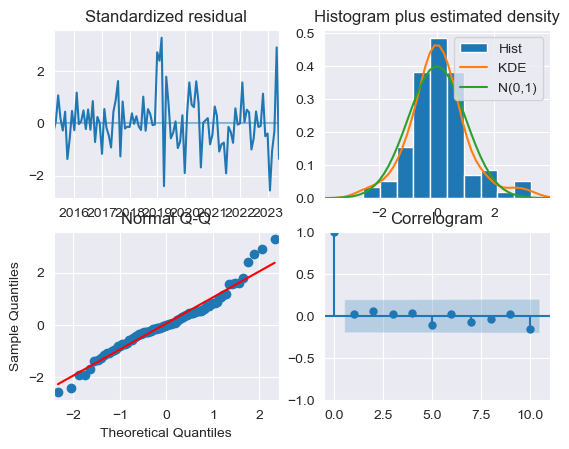

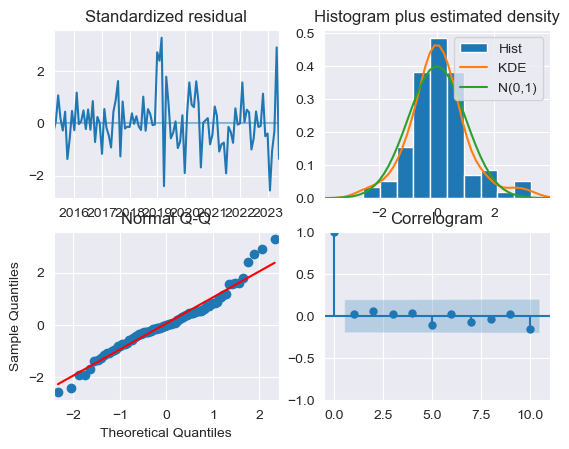

In [45]:
auto_arima_results.plot_diagnostics()

In [46]:
sarima_model_volume = SARIMAX(
    endog=df_train['volume'], 
    order=auto_arima_results.order, # what happened last x months suggest non-seasonal MA
    seasonal_order=auto_arima_results.seasonal_order, # what happened last year suggest seasonal RA
    # enforce_stationarity=False,
    # enforce_invertibility=False,
)

sarima_results_volume = sarima_model_volume.fit(disp=False)

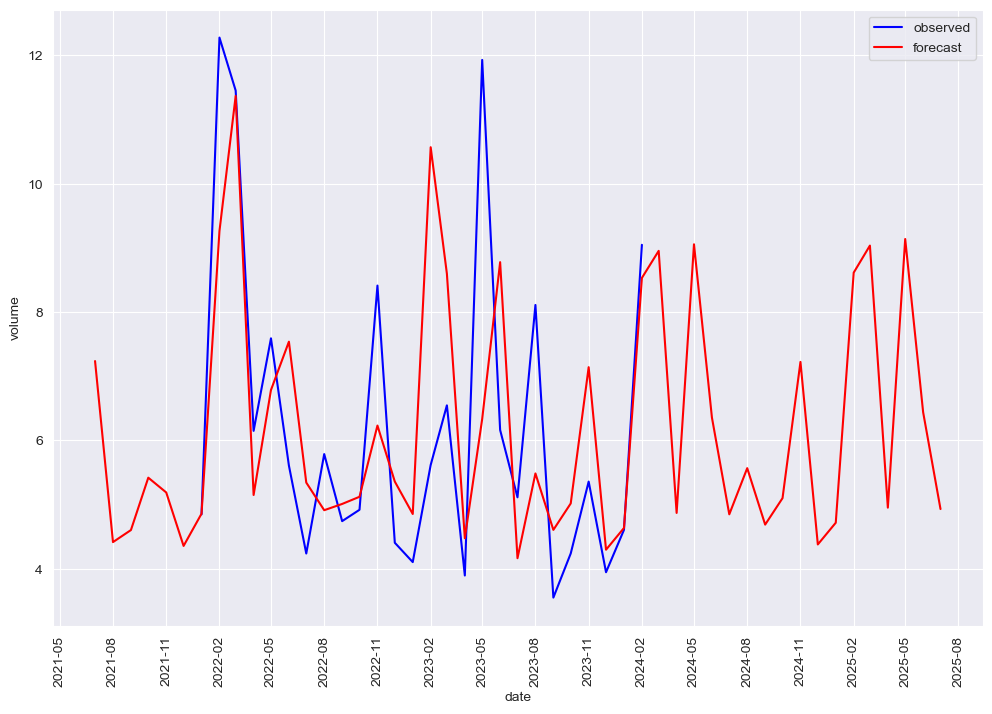

In [68]:
# forcasting out of sample 12 months in future, using one step ahead
# forecast = results.get_forecast(steps=12, dynamic=False)
sarima_forecast_volume = sarima_results_volume.predict(
    start=len(df_train) - 24, 
    end=len(df_train) + 24, 
    dynamic=False
)

# extract predicted forecasts, in our case by month
# mean_forecast = forecast.predicted_mean

fig, axes = plt.subplots(1,1, figsize=(12,8))

# plot actual
sns.lineplot(marketstack_monthly['2022':]['volume'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(sarima_forecast_volume,
             color='red',
             label='forecast',
             ax=axes)

axes = change_ticker(axes)

plt.show()

In [48]:
# end = df_test.iloc[-1:]
end = df_test.last_valid_index()
end

Timestamp('2024-02-01 00:00:00')

In [49]:
df_test

GT    volume  dividend
date                                     
2023-07-01  14.802143  5.112814       0.0
2023-08-01  12.958571  8.109543       0.0
2023-09-01  12.644286  3.550771       0.0
2023-10-01  12.235714  4.238200       0.0
2023-11-01  13.084286  5.358229       0.0
2023-12-01  14.293571  3.946029       0.0
2024-01-01  13.841429  4.605829       0.0
2024-02-01  12.976429  9.046845       0.0

In [50]:
sarima_forecast_volume.loc[end:]
df_volume_test = sarima_forecast_volume.loc[end:][1:].to_frame()
df_volume_test.columns = ['volume']
df_volume_test.head(10)

volume
2024-03-01  8.952476
2024-04-01  4.869872
2024-05-01  9.054791
2024-06-01  6.355567
2024-07-01  4.848118
2024-08-01  5.567149
2024-09-01  4.687706
2024-10-01  5.099851
2024-11-01  7.222510
2024-12-01  4.378765

In [51]:
df_volume_test = pd.concat([df_test, df_volume_test])
df_volume_test

GT    volume  dividend
2023-07-01  14.802143  5.112814       0.0
2023-08-01  12.958571  8.109543       0.0
2023-09-01  12.644286  3.550771       0.0
2023-10-01  12.235714  4.238200       0.0
2023-11-01  13.084286  5.358229       0.0
2023-12-01  14.293571  3.946029       0.0
2024-01-01  13.841429  4.605829       0.0
2024-02-01  12.976429  9.046845       0.0
2024-03-01        NaN  8.952476       NaN
2024-04-01        NaN  4.869872       NaN
2024-05-01        NaN  9.054791       NaN
2024-06-01        NaN  6.355567       NaN
2024-07-01        NaN  4.848118       NaN
2024-08-01        NaN  5.567149       NaN
2024-09-01        NaN  4.687706       NaN
2024-10-01        NaN  5.099851       NaN
2024-11-01        NaN  7.222510       NaN
2024-12-01        NaN  4.378765       NaN
2025-01-01        NaN  4.717143       NaN
2025-02-01        NaN  8.613381       NaN
2025-03-01        NaN  9.034633       NaN
2025-04-01        NaN  4.952029       NaN
2025-05-01        NaN  9.136948       NaN
2025-06-01        NaN  6.437724       NaN
2025-07-01        NaN  4.930275       NaN

# Fitting a baseline model

In [52]:
# Instantiate the model

model_arima = ARIMA(
    endog=df_train['GT'],
    order=(12,1,3),
)

arima_results = model_arima.fit()

model_arima_exog = ARIMA(
    endog=df_train['GT'],
    exog=df_train[['volume']],
    order=(12,1,3),
)

arima_results_exog = model_arima_exog.fit()

# Print out summary information on the fit
print(arima_results.summary())
print(arima_results_exog.summary())

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                     GT   No. Observations:                  112
Model:                ARIMA(12, 1, 3)   Log Likelihood                -219.910
Date:                Mon, 18 Mar 2024   AIC                            471.821
Time:                        17:55:06   BIC                            515.173
Sample:                    03-01-2014   HQIC                           489.408
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2438      0.127      1.913      0.056      -0.006       0.494
ar.L2          0.1586      0.132      1.197      0.231      -0.101       0.418
ar.L3         -0.7939      0.128     -6.189      0.0

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


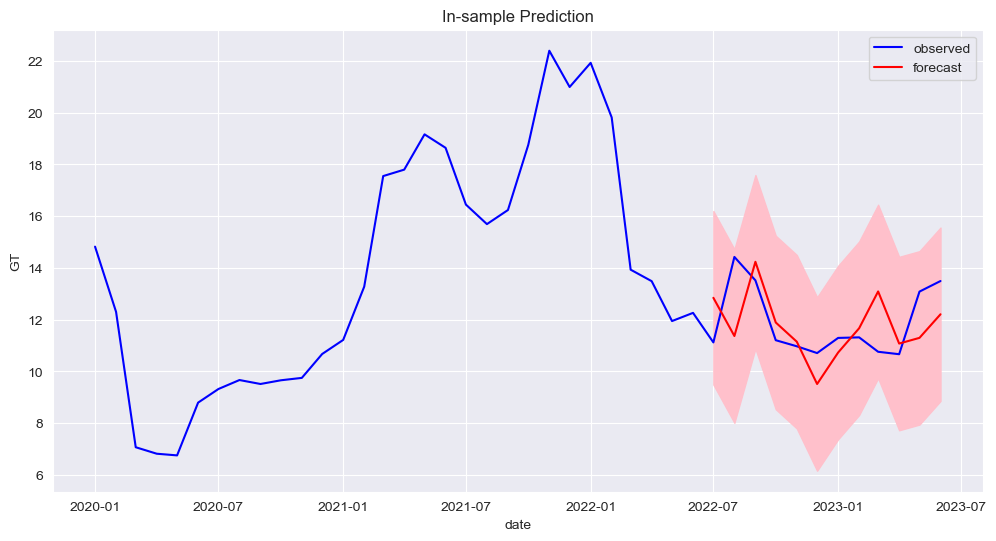

In [53]:
# generate in-sample forecasts, using the last steps of training data

# make predictions for last 25 entries of training data, using one-step ahead
forecast_arima_base_train = arima_results.get_prediction(start=-12, dynamic=False)

# extract predicted forecasts, in our case by month
mean_forecast = forecast_arima_base_train.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast_arima_base_train.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1, figsize=(12,6))
# plot actual/observed
sns.lineplot(df_train['2020':]['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(mean_forecast,
             color='red',
             label='forecast',
             ax=axes)

# shade confidence levels / uncertainty
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('In-sample Prediction')
plt.show()


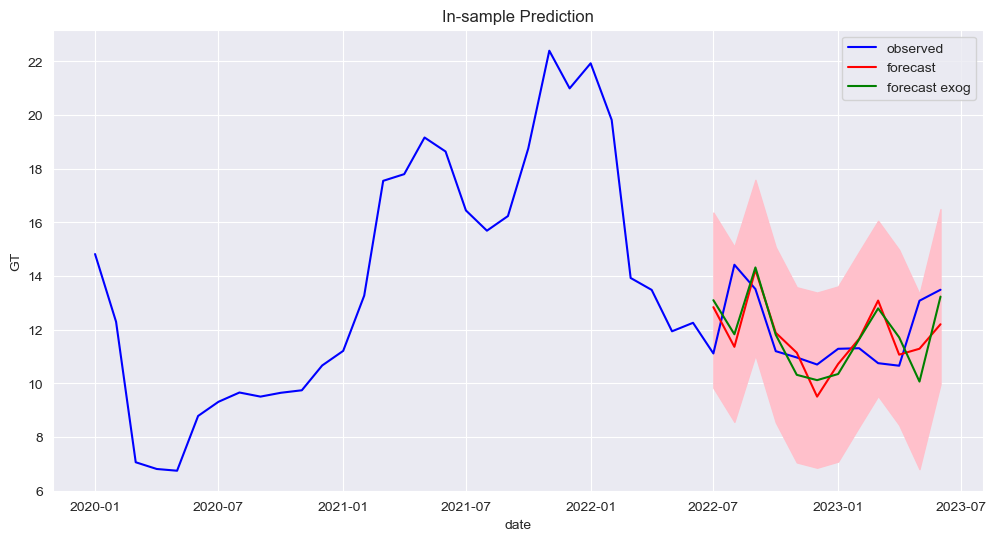

In [54]:
# generate in-sample forecasts, using the last steps of training data

# make predictions for last 25 entries of training data, using one-step ahead
forecast_arima_base_train_exog = arima_results_exog.get_prediction(start=-12, dynamic=False)

# get confidence levels of predictions
confidence_intervals = forecast_arima_base_train_exog.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1, figsize=(12,6))
# plot actual/observed
sns.lineplot(df_train['2020':]['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_train.predicted_mean,
             color='red',
             label='forecast',
             ax=axes)


# plot prediction
sns.lineplot(forecast_arima_base_train_exog.predicted_mean,
             color='green',
             label='forecast exog',
             ax=axes)

# shade confidence levels / uncertainty
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('In-sample Prediction')
plt.show()


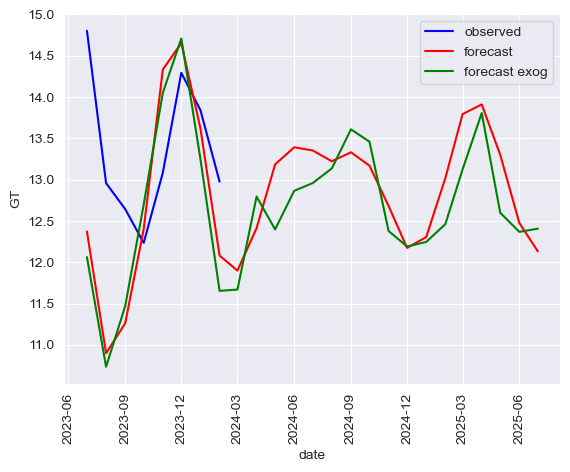

In [55]:
# forcasting out of sample 12 months in future, using one step ahead
# forecast = results.get_forecast(steps=12, dynamic=False)
start = len(df_train)
end = len(df_train) + 24

forecast_arima_base_test = arima_results.predict(
    start=start, 
    end=end,
    dynamic=False)

forecast_arima_base_test_exog = arima_results_exog.predict(
    start=start, 
    end=end,
    exog=df_volume_test['volume'][:end],
    dynamic=False)

fig, axes = plt.subplots(1,1)

# plot actual
sns.lineplot(df_test['2020':]['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test,
             color='red',
             label='forecast',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test_exog,
             color='green',
             label='forecast exog',
             ax=axes)

axes = change_ticker(axes)

plt.show()

## Step 5: Model diagnostics

Before we use the model to predict, we want to know how good the model predictions are.
MAE is a good measure for this - mean difference between predictions and true values

In [56]:
# extract the errors (residuals)
residuals = arima_results.resid

# calcalte the mean absolute error
mae = np.mean(np.abs(residuals))
print('MAE: {}'.format(mae))


MAE: 1.6043276254008692


In [57]:
# extract the errors (residuals)
residuals = arima_results_exog.resid

# calcalte the mean absolute error
mae = np.mean(np.abs(residuals))
print('MAE: {}'.format(mae))


MAE: 1.5870823995914223


#### plot_diagostics:
- plot 1: there should be no obvious structure in residuals
- plot 2: distribution of residuals should be normalized. If model is good orange and green lines should be close together
- plot 3: compare distribution of model residuals to a normal distribution, all the residuals should lie along the red line
- plot 4: correlogram - ACF plot using residuals. 95% of correlations for lag > 0 should not be significant.

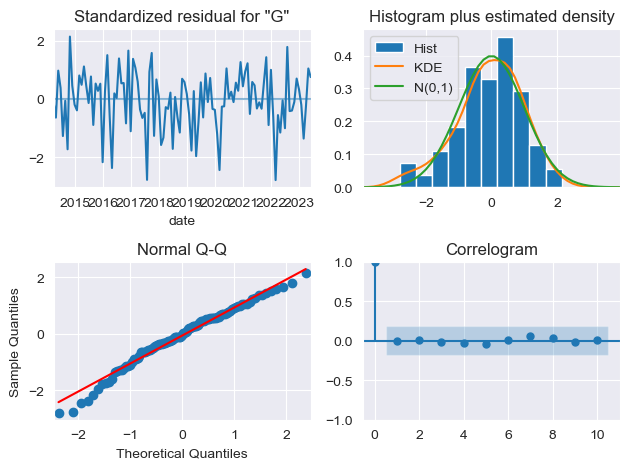

In [58]:
# For an ideal model, the residuals shoudl be uncorrelat3eed white Gaussian noice centered on zero
ax = arima_results.plot_diagnostics()
plt.tight_layout()

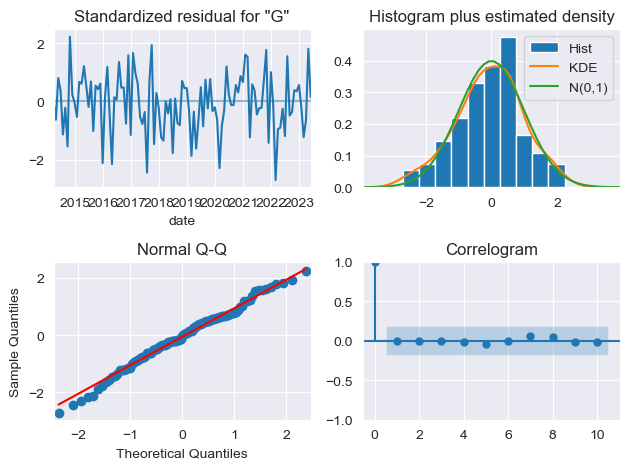

In [59]:
# For an ideal model, the residuals shoudl be uncorrelat3eed white Gaussian noice centered on zero
ax = arima_results_exog.plot_diagnostics()
plt.tight_layout()

#### Summary statistics
- Prob(Q) - Ljung-Box: pvalue associated with the null hypothesis that the residuals have no correlation structure. 
- Prob(JB) - Jarque Bera: pvalue for null hypothesis that residuals are normal
    
If either p_value < 0.05, this is bad, and we should reject the null hypothesis, and go back and improve our modelling.

In [60]:
print(arima_results_exog.summary())

                               SARIMAX Results                                
Dep. Variable:                     GT   No. Observations:                  112
Model:                ARIMA(12, 1, 3)   Log Likelihood                -217.135
Date:                Mon, 18 Mar 2024   AIC                            468.270
Time:                        17:55:10   BIC                            514.332
Sample:                    03-01-2014   HQIC                           486.956
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume        -0.1470      0.063     -2.333      0.020      -0.271      -0.024
ar.L1          0.2050      0.143      1.429      0.153      -0.076       0.486
ar.L2          0.1375      0.128      1.075      0.2

|**Conclusion**:
With Prod(JB) < 0.05 we reject the null hypothis that residuals are normally distributed.
There might be some outliers, like with huge drop 2018-2020, some more transformations might be needed.

Since the data is seasonal we will always have correlated residuals left if we try to fit an ARIMA model to it. This means that we aren't using all of the information in the data, and so we aren't making the best predictions possible

# Hyper parameter tuning
### Compute ACF and PACF
To identify the ARIMA model parameters, we use ACF and PACF to help us select hyper parameters for RA or MA order.
Series must be stationary **before** we use ACF and PACF


Now that the time series is stationary, compute the sample ACF and PACF. This will provide some guidance on the order of the ARIMA model to use.

#### **Autocorrelation**
The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

When you look at the correlation of say, two stocks, you should look at the correlation of their *returns*, not their levels, it makes them more comparable.

What does it mean when a series has a positive or negative autocorrelation? 
- With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting". Mean reversion is a financial theory which suggests that, after an extreme price move, asset prices tend to return back to normal or average levels.
- If a series has positive autocorrelation, we say it is "trend-following".

Many hedge fund strategies are only slightly more complex versions of mean reversion and momentum strategies. Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up. For other assets like commodities and currencies, they have historically had positive autocorrelation over horizons of several months, so the typical hedge fund strategy there is to buy commodities that have gone up in the last several months and sell those commodities that have gone down.



#### **Autocorrelation function (ACF)**
The sample autocorrelation function, or ACF,shows not only the lag-one autocorrelation from the last chapter, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past.

In plot_acf, the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations. An approximation to the width of the 95% confidence intervals, if you make some simplifying assumptions, is plus or minus 2 over the square root of the number of observations in your series. Incidentally, if you don't want to see confidence intervals in your plot, set alpha equal to one.


- ACF measures the linear dependence between data points in a time series at different time lags. It calculates the correlation coefficient between a variable and its lagged version for various time lags. A high autocorrelation value indicates that the observations are closely related to their preceding observations.
- ACF is used to identify the appropriate order of the moving average (MA) component in a time series model.





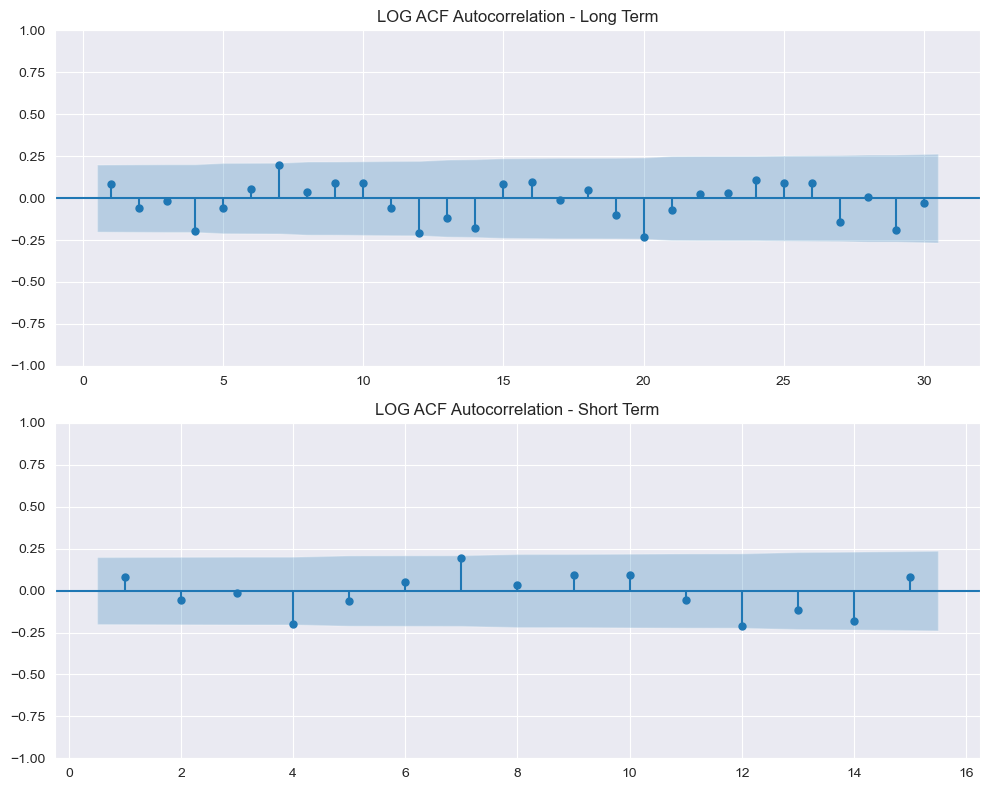

In [61]:

marketstack_diff = marketstack_monthly.diff().dropna()

fig, axes = plt.subplots(2,1, figsize=(10,8))

# Plot the ACF
ax1 = tsaplots.plot_acf(marketstack_diff['2016': '2023']['GT'], 
                  lags=30, 
                  zero=False, 
                  # alpha=0.05, 
                  ax=axes[0])
axes[0].title.set_text('LOG ACF Autocorrelation - Long Term')

# Plot the PACF
tsaplots.plot_acf(marketstack_diff['2016': '2023']['GT'], 
                  lags=15, 
                  zero=False, 
                  # alpha=0.05, 
                  ax=axes[1])
axes[1].title.set_text('LOG ACF Autocorrelation - Short Term')
plt.tight_layout()

#### Partial Autocorrelation function  (PAFC)
The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.
    
- PACF measures the direct linear dependence between data points in a time series at a specific time lag, after removing the effect of any correlations at shorter lags. In other words, it calculates the correlation between a variable and its lagged version, while controlling for the influence of all intervening data points.
- PACF is used to identify the appropriate order of the autoregressive (AR) component in a time series model.

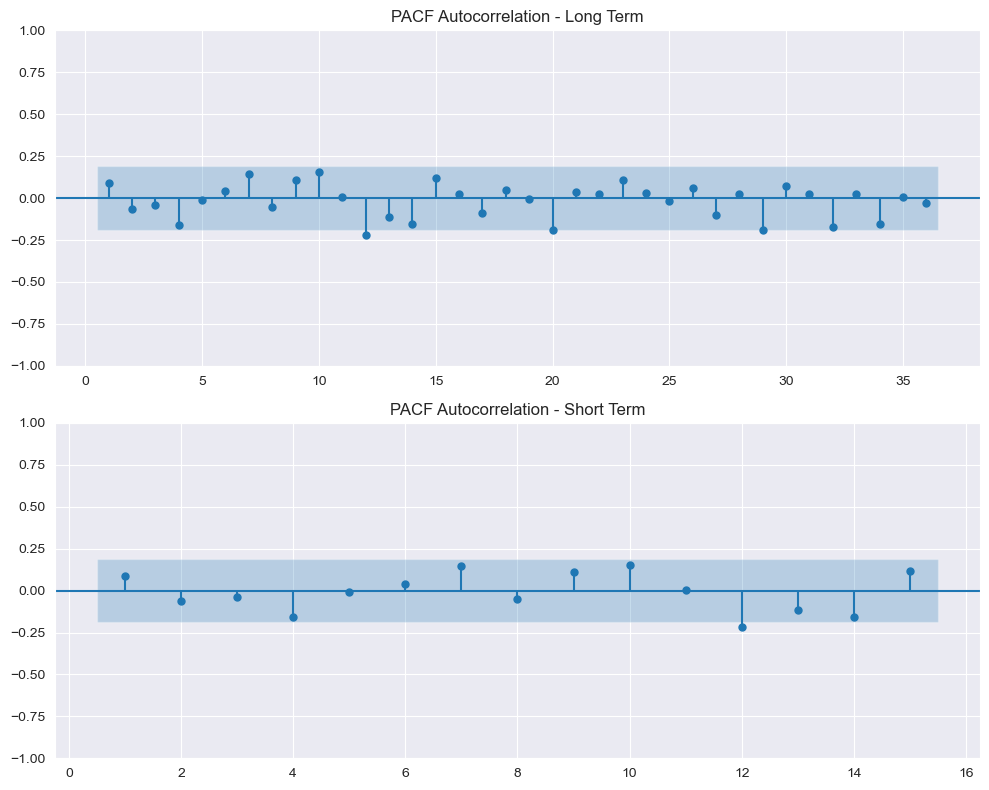

In [62]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF
ax1 = tsaplots.plot_pacf(marketstack_diff['2015': '2023']['GT'],
                        lags=36,
                        zero=False,
                        # alpha=0.05,
                        ax=axes[0])
axes[0].title.set_text('PACF Autocorrelation - Long Term')

# Plot the PACF
tsaplots.plot_pacf(marketstack_diff['2015': '2023']['GT'],
                  lags=15,
                  zero=False,
                  # alpha=0.05,
                  ax=axes[1])
axes[1].title.set_text('PACF Autocorrelation - Short Term')
plt.tight_layout()

> No plot is trailing off, and both show a seasonal pattern. This is thus either a ARMA model or seasonal

**Conclusion**
None of ACF or PACF tails off, so this means we have a ARMA model
We have to do find lowest BIC or AIC to find the best model parameters


## Step x:  How to know which order to use ?

**1. AIC and BIC**

In the last lesson, we mentioned how ACF and PACF can't be used to choose the order of a model, when both of the orders p and q are non-zero. However there are more tools we can use, the AIC and the BIC.

**2. AIC - Akaike information criterion**

The Akaike information criterion, or AIC, is a metric which tells us how good a model is. A model which makes better predictions is given a lower AIC score. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data.

**3. BIC - Bayesian information criterion**

The Bayesian information criterion, or BIC, is very similar to the AIC. Models which fit the data better have lower BICs and the BIC penalizes overly complex models.

**4. AIC vs BIC**

For both of these metrics a lower value suggests a better model. The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However if our goal is to identify a good explanatory model, we should use BIC.




In [63]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-12
for p in range(13):
    
  # Loop over q values from 0-12
    for q in range(13):
        
        for d in range(3):
        
            try:
                
                # create and fit ARMA(p,q) model
                model = ARIMA(df_train['GT'], 
                              order=(p,d,q),
                              exog=df_train[['volume']]
                              )
                
                results = model.fit(method_kwargs={"warn_convergence": False})
            
                # Append order and results tuple
                order_aic_bic.append((p, q, d, results.aic, results.bic))
                
            except:
                pass

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

In [64]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'd', 'AIC', 'BIC'])

order_df.sort_values('AIC', inplace=True)

print(order_df)

      p  q  d         AIC         BIC
367   9  5  1  463.708326  507.060809
43    1  1  1  464.879340  475.717461
406  10  5  1  465.814269  511.876282
127   3  3  1  465.926721  487.602963
106   2  9  1  466.017361  501.241254
..   .. .. ..         ...         ...
12    0  4  0  538.378057  557.407549
9     0  3  0  562.942570  579.253563
6     0  2  0  607.441167  621.033661
3     0  1  0  667.649114  678.523110
0     0  0  0  780.932582  789.088078

[507 rows x 5 columns]


In [65]:
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

      p   q  d         AIC         BIC
1     0   0  1  466.652203  472.071264
43    1   1  1  464.879340  475.717461
4     0   1  1  468.033855  476.162446
40    1   0  1  468.128992  476.257582
5     0   1  2  469.815371  477.916813
..   ..  .. ..         ...         ...
462  11  11  0  498.248820  566.211292
9     0   3  0  562.942570  579.253563
6     0   2  0  607.441167  621.033661
3     0   1  0  667.649114  678.523110
0     0   0  0  780.932582  789.088078

[507 rows x 5 columns]


### Lets try model with these new parameters

In [66]:
# Instantiate the model
model_arima_auto = ARIMA(
    df_train['GT'], 
    order=(9,1,5),
    exog=df_train[['volume']],    
    trend=None,
)

arima_results_auto = model_arima_auto.fit()

# Print out summary information on the fit
print(arima_results_auto.summary())

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                     GT   No. Observations:                  112
Model:                 ARIMA(9, 1, 5)   Log Likelihood                -215.854
Date:                Mon, 18 Mar 2024   AIC                            463.708
Time:                        18:02:54   BIC                            507.061
Sample:                    03-01-2014   HQIC                           481.295
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume        -0.1437      0.066     -2.179      0.029      -0.273      -0.014
ar.L1          0.7313      0.173      4.218      0.000       0.391       1.071
ar.L2         -0.6906      0.195     -3.544      0.0

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


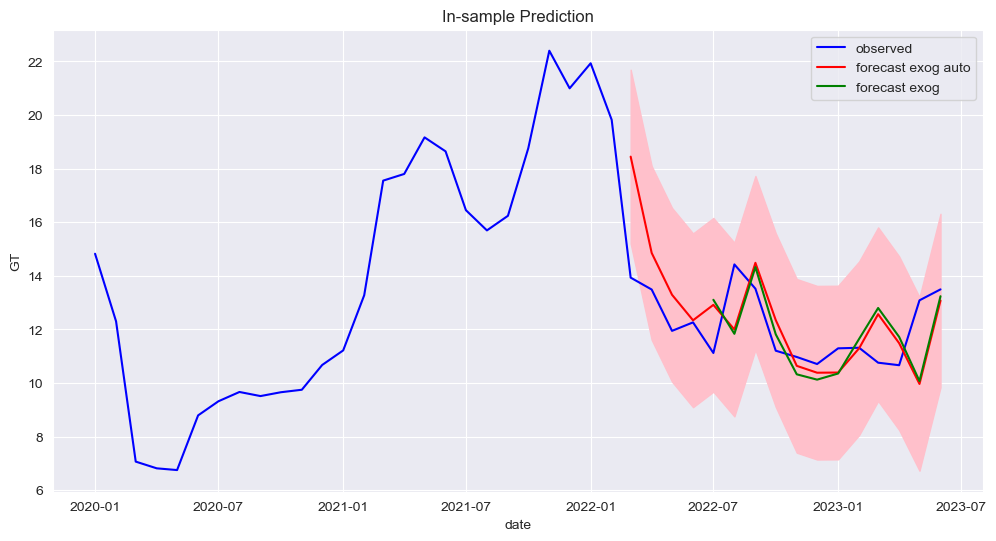

In [69]:
# generate in-sample forecasts, using the last steps of training data

# make predictions for last 25 entries of training data, using one-step ahead
forecast_arima_results_auto_train = arima_results_auto.get_prediction(start=-16, dynamic=False)

# extract predicted forecasts, in our case by month
mean_forecast = forecast_arima_results_auto_train.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast_arima_results_auto_train.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1, figsize=(12,6))
# plot actual/observed
sns.lineplot(df_train['GT']["2020":],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_results_auto_train.predicted_mean,
             color='red',
             label='forecast exog auto',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_train_exog.predicted_mean,
             color='green',
             label='forecast exog',
             ax=axes)

# shade confidence levels / uncertainty
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('In-sample Prediction')
plt.show()

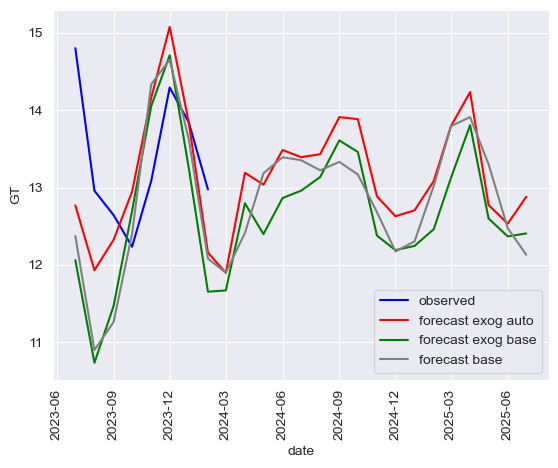

In [71]:
# forcasting out of sample 12 months in future, using one step ahead

start = len(df_train)
end = len(df_train) + 24
forecast_arima_results_auto_test = arima_results_auto.predict(
    start=start, 
    end=end,
    exog=df_volume_test['volume'][:end],
    dynamic=False)

fig, axes = plt.subplots(1,1)

# plot actual
sns.lineplot(df_test['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_results_auto_test,
             color='red',
             label='forecast exog auto',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test_exog,
             color='green',
             label='forecast exog base',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test,
             color='grey',
             label='forecast base',
             ax=axes)

axes = change_ticker(axes)

plt.show()

In [72]:
# extract the errors (residuals)
residuals = arima_results_auto.resid

# calcalte the mean absolute error
mae = np.mean(np.abs(residuals))
print('MAE: {}'.format(mae))

MAE: 1.5806502635521482


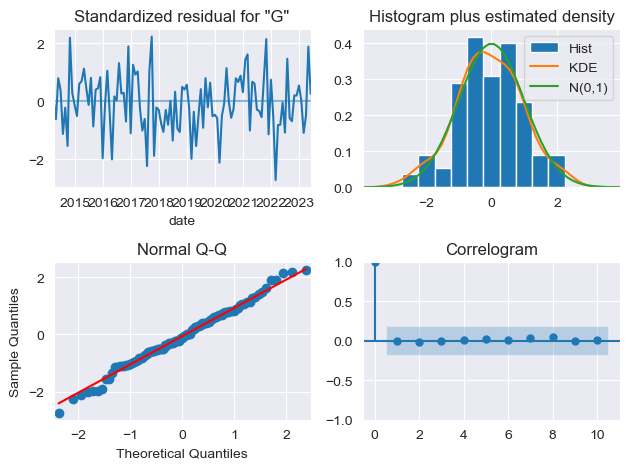

In [73]:
ax = arima_results_auto.plot_diagnostics()
plt.tight_layout()

# Box-Jenkins methods
It's a methodology to follow to build the best ARIMA models

1) Identification
- Is the time series stationary ?
- What differencing will make it stationary ?
- What transforms will make it statiionary ?
- What values of p and q are most promising ?
- We use: df.plot, adfuller(), .diff(), np.log(), np.sqrt(), plot_acf, plot_pacf

2) Estimation
- model.fit()
- results.aic, results.bic 

3) model diagostics
- results.plot_diagnostics()
- results.summary()

4) model ok ?

5) make forecasts / production

# Step x: Seasonality

SARIMA model
- It's like fitting 2 models, one for seasonal part, and another for non-seasonal part

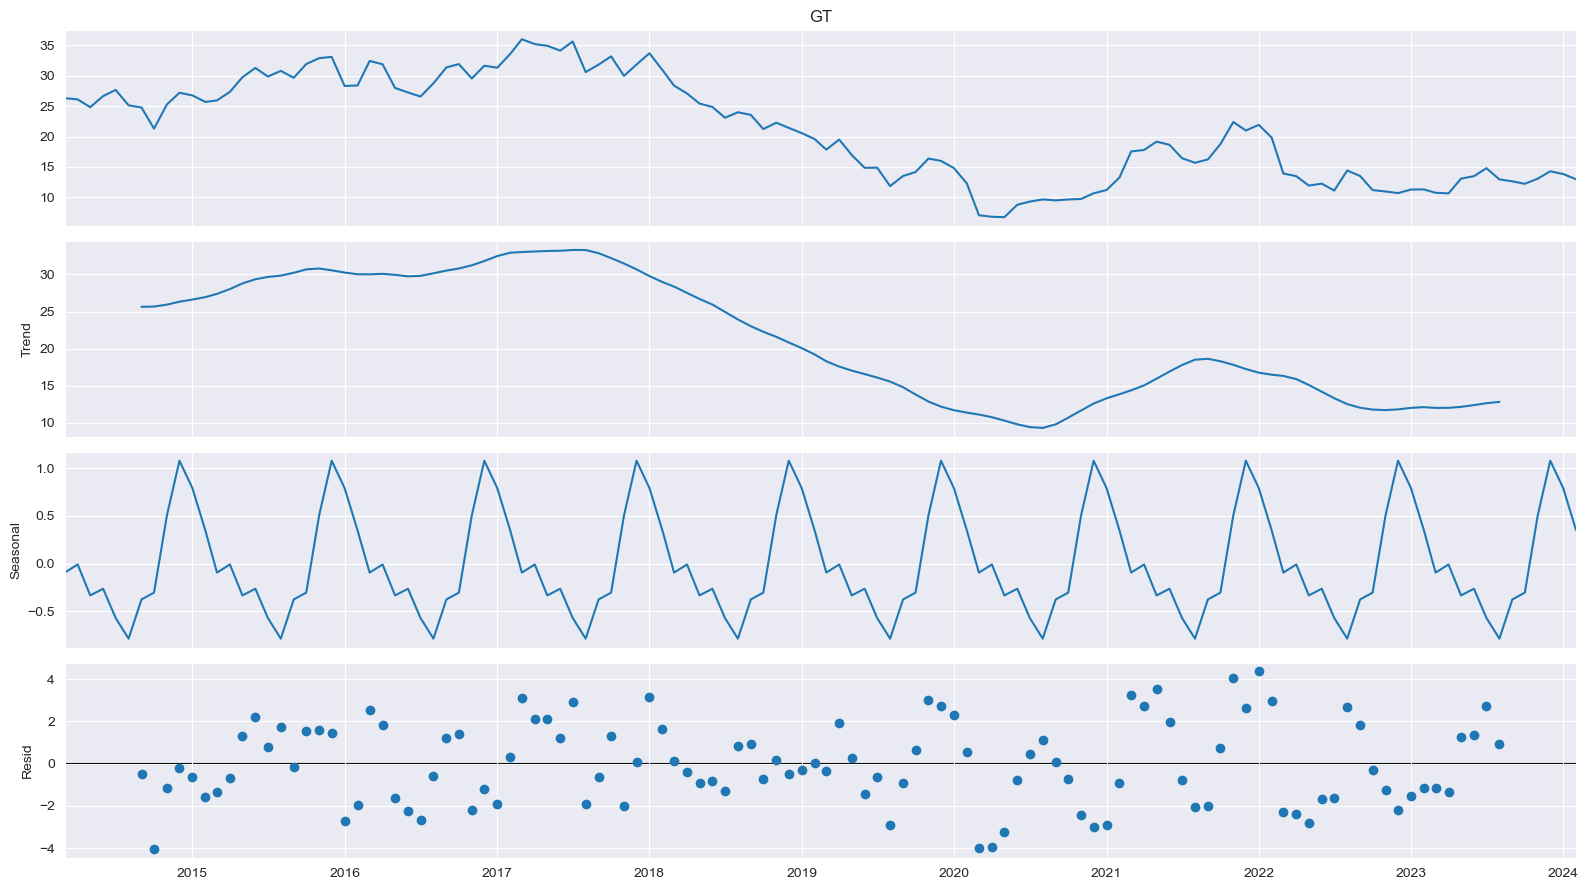

In [74]:
decomposition = seasonal_decompose(
    marketstack_monthly['GT'],
    # period=6,
    # extrapolate_trend=12,
    # model='multiplicative'
)

fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.tight_layout()

<Axes: xlabel='date'>

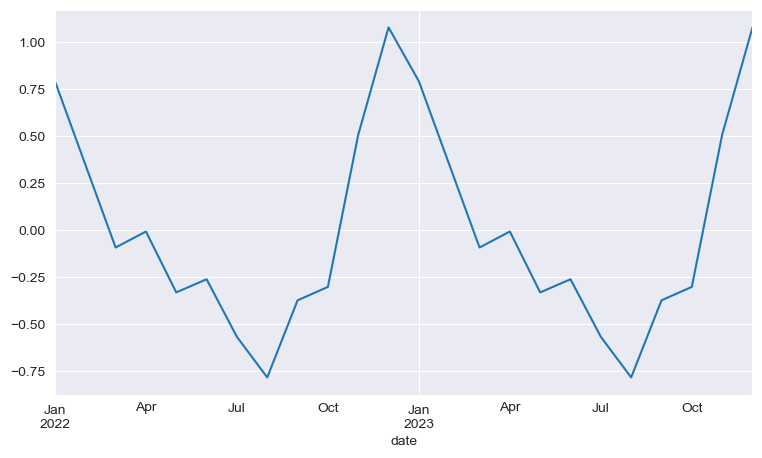

In [75]:
#Drilling Down and Observing Seasonality
fig = plt.figure(figsize=(9,5))
decomposition.seasonal['2022':'2023'].plot()

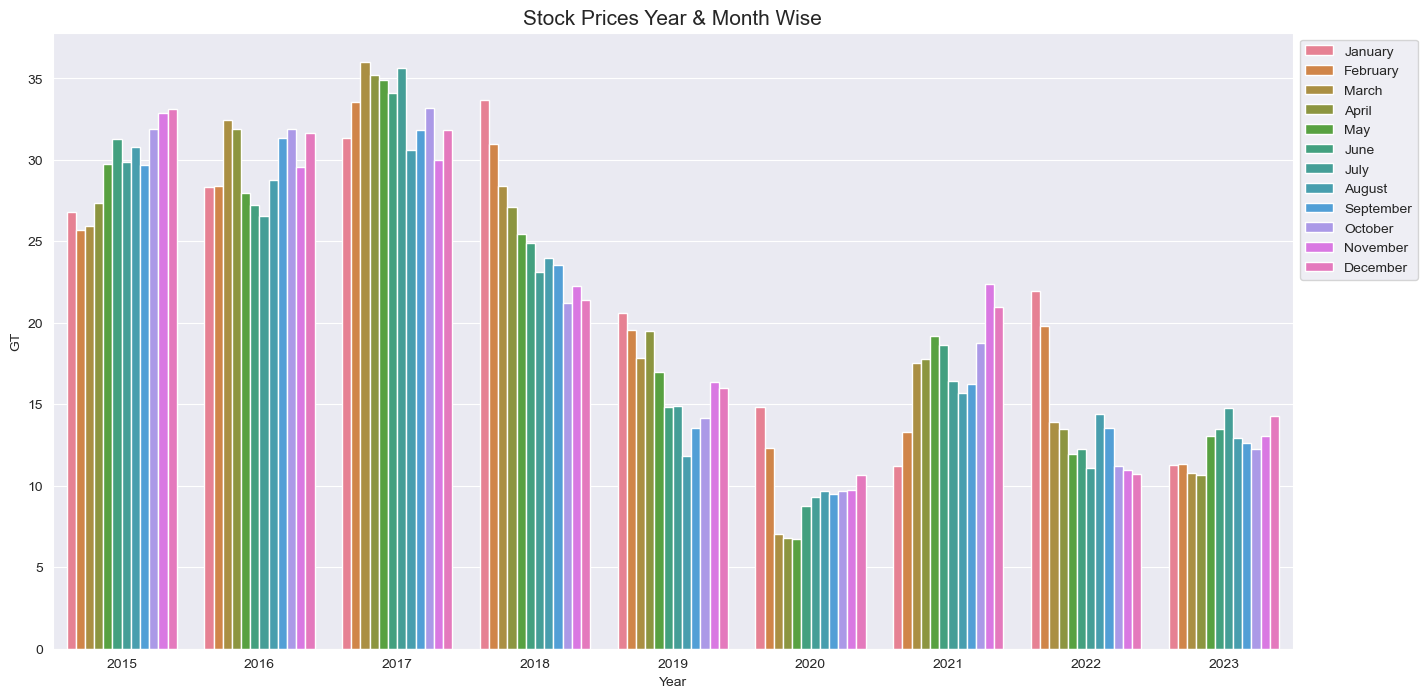

In [76]:
# Can we manually spot seasonality trends with a year?

data = marketstack_monthly['2015':'2023'].copy(deep=True)
data['Year'] = marketstack_monthly['2015':'2023'].index.year
data['Month'] = marketstack_monthly['2015':'2023'].index.strftime('%B')
data['Quarter'] = marketstack_monthly['2015':'2023'].index.quarter
fig, ax = plt.subplots(figsize=(16,8))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="GT", hue='Month',data=data, ax=ax)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

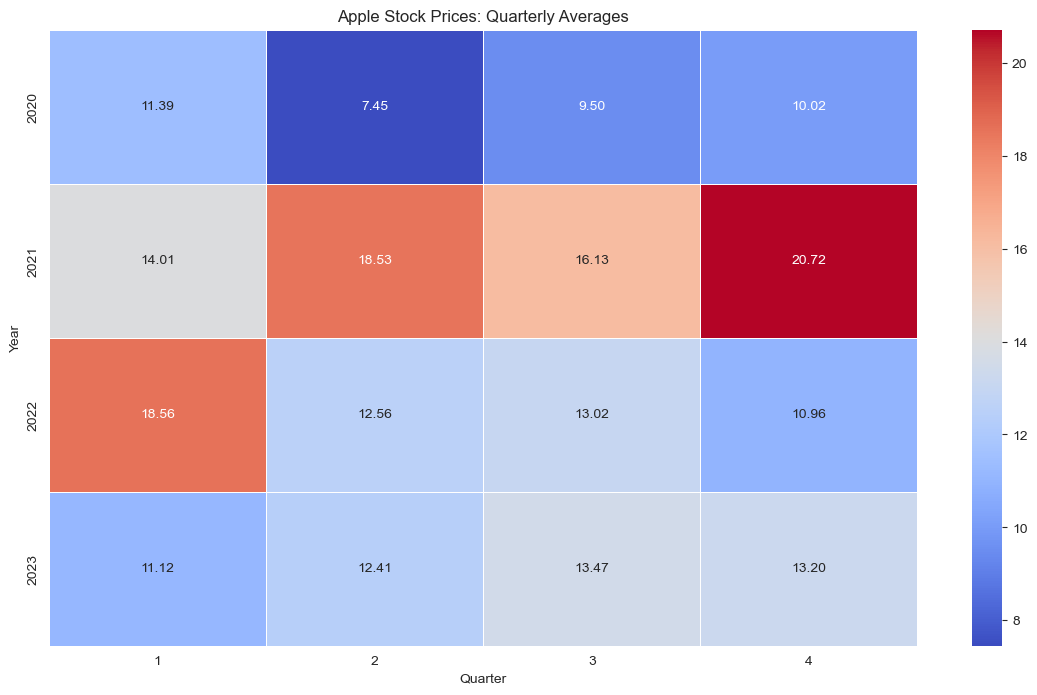

In [77]:
# Can we manually spot seasonality trends with a quarter ?
quarter = data['2020':'2023'].groupby(["Year", "Quarter"])["GT"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Apple Stock Prices: Quarterly Averages")
plt.show()

We need to know how often the time series repeat, we can use ACF for this.
    We look for a lag > 1 that is a peak in the ACF plot

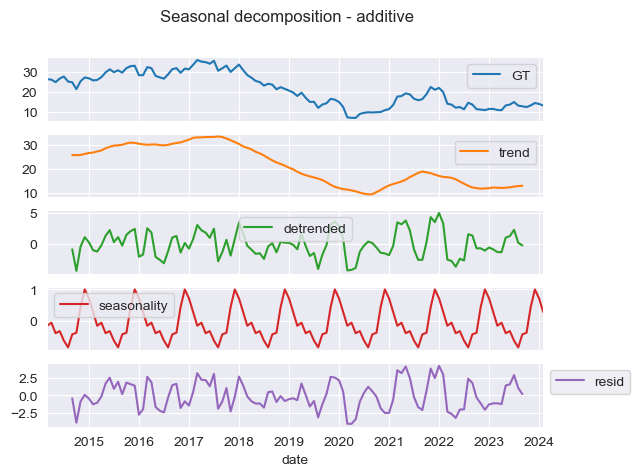

In [78]:
# manually simulate seasonal_decompose to understand the calculations

df = marketstack_monthly.copy()

# calculate the trend
df['trend'] = df['GT'].rolling(window=12, center=True).mean()

# detrend the series
df['detrended'] = df['GT'] - df['trend']

# calculate the seasonal component
df["month"] = df.index.month
df["seasonality"] = df.groupby("month")["detrended"].transform("mean")

# get residuals
df["resid"] = df['detrended'] - df['seasonality']

(
    df
    .loc[:, ["GT", "trend", "detrended", 'seasonality', 'resid']]
    .plot(subplots=True, title="Seasonal decomposition - additive")
)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

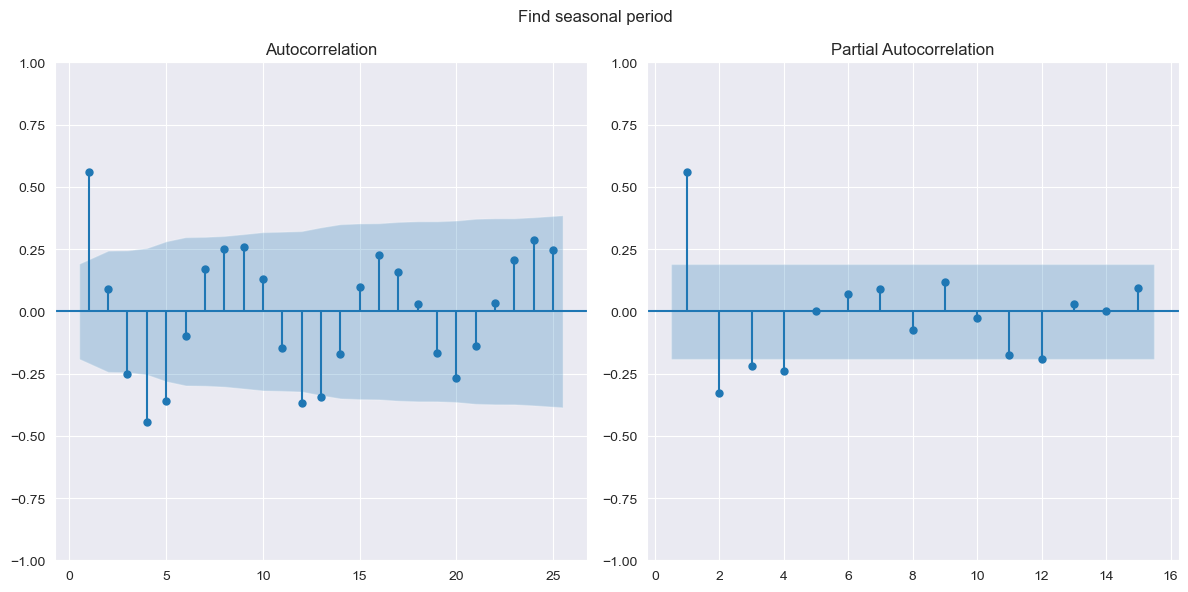

In [79]:
# We need to know how often the time series repeat, we can use ACF for this and subtract rolling mean from itself.

# df = marketstack_monthly - marketstack_monthly.rolling(24).mean()
df = df.dropna()
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12,6))

plot_acf(df['detrended']['2015':], lags=25, zero=False, ax=axes[0])
plot_pacf(df['detrended']['2015':], lags=15, zero=False, ax=axes[1])

plt.suptitle('Find seasonal period')
plt.tight_layout()

<Axes: xlabel='date'>

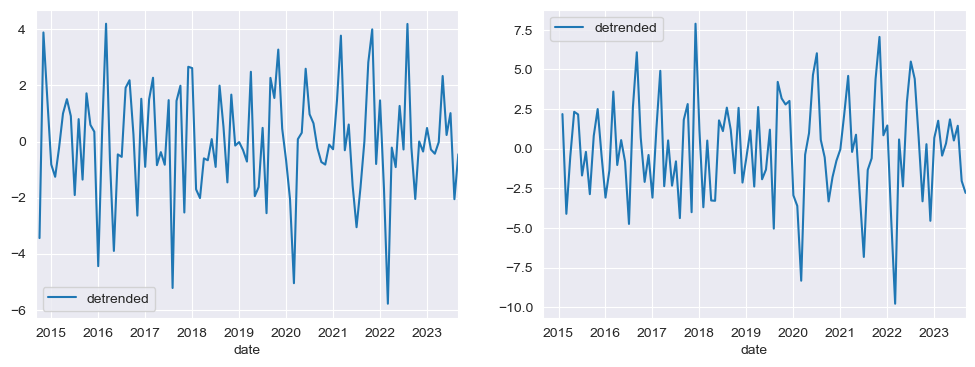

In [80]:
# calculate differencing
fig, axes = plt.subplots(1,2, figsize=(12,4))

df_diff = df['detrended'].diff().to_frame()
df_diff.plot(ax=axes[0])

df_diff = df_diff.diff(4)
df_diff.plot(ax=axes[1])

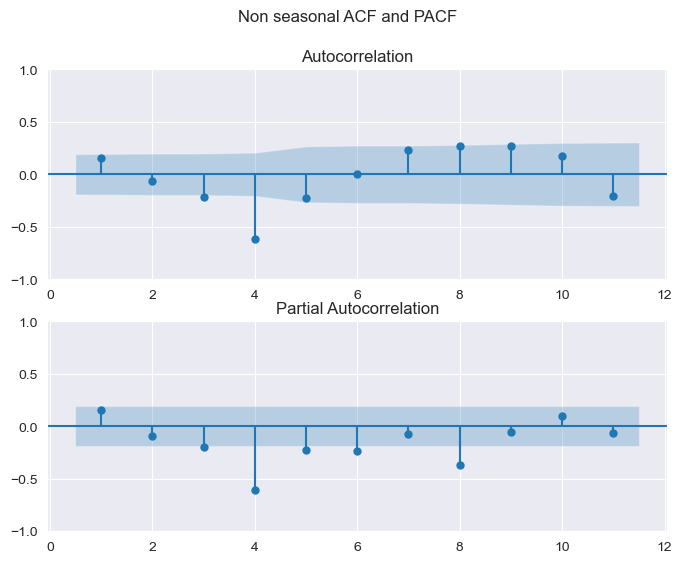

In [81]:
# create non-seasonal ACF and PACF plots

df_diff = df_diff.dropna()

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_diff['detrended'], lags=11, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_diff['detrended'], lags=11, zero=False, ax=ax2)

plt.suptitle('Non seasonal ACF and PACF')
plt.show()

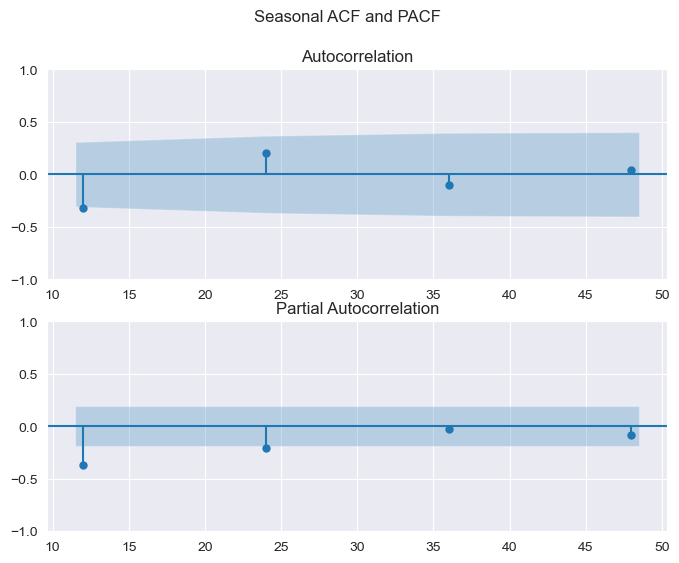

In [82]:
# Seasonal ACF, PACF
seasonal_lags = [12, 24, 36, 48]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(df_diff['detrended'], lags=seasonal_lags, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_diff['detrended'], lags=seasonal_lags, ax=ax2)

plt.suptitle('Seasonal ACF and PACF')
plt.show()

> PACF tails off, whilst ACF cuts off after lag 12

The non-seasonal ACF doesn't show any of the usual patterns of MA, AR or ARMA models so we choose none of these. The Seasonal ACF and PACF look like an MA(1) model. We select the model that combines both of these, being (0,1,0, 0.1.1,12)

model = SARIMAX(df, order=(), seasonal_order())
results = model.fit()

In [85]:
## Instantiate the model

# Here is an example of a mixed model that could be used for monthly data. 
# You see that this month's value is related to last year using a seasonal AR(1). 
# In addition, this month's value is related to last month's shock (or error).

# SAR(1) - Value this month is related to last year's value
# MA(1) - This months value is related to last x month's shock    
    
# # lets detrend the time series by ourselves
# df = marketstack_monthly.copy()
# 
# # calculate the trend
# df['trend'] = df['GT'].rolling(window=12, center=True).mean()
# 
# # detrend the series
# df['GT'] = df['GT'] - df['trend']
# 
# # split dataset into train and test data
# df_train_sarima = df['GT'] .loc[:'202306']
# df_test_sarima = df['GT'] .loc['202307':]
    
sarima_model_base = SARIMAX(
    endog=df_train['GT'], 
    exog=df_train[['volume']],
    order=(0,1,3), # what happened last x months suggest non-seasonal MA
    seasonal_order=(3,1,1,4), # what happened last year suggest seasonal RA)
    # trend='ct',
    # simple_differencing=True,
) 

sarima_results_base = sarima_model_base.fit(disp=False)

print(sarima_results_base.summary())

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                                  GT   No. Observations:                  112
Model:             SARIMAX(0, 1, 3)x(3, 1, [1], 4)   Log Likelihood                -227.811
Date:                             Mon, 18 Mar 2024   AIC                            473.622
Time:                                     18:10:00   BIC                            497.678
Sample:                                 03-01-2014   HQIC                           483.374
                                      - 06-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume        -0.1305      0.078     -1.673      0.094      -0.283       0.022
ma.L1          0.0647      

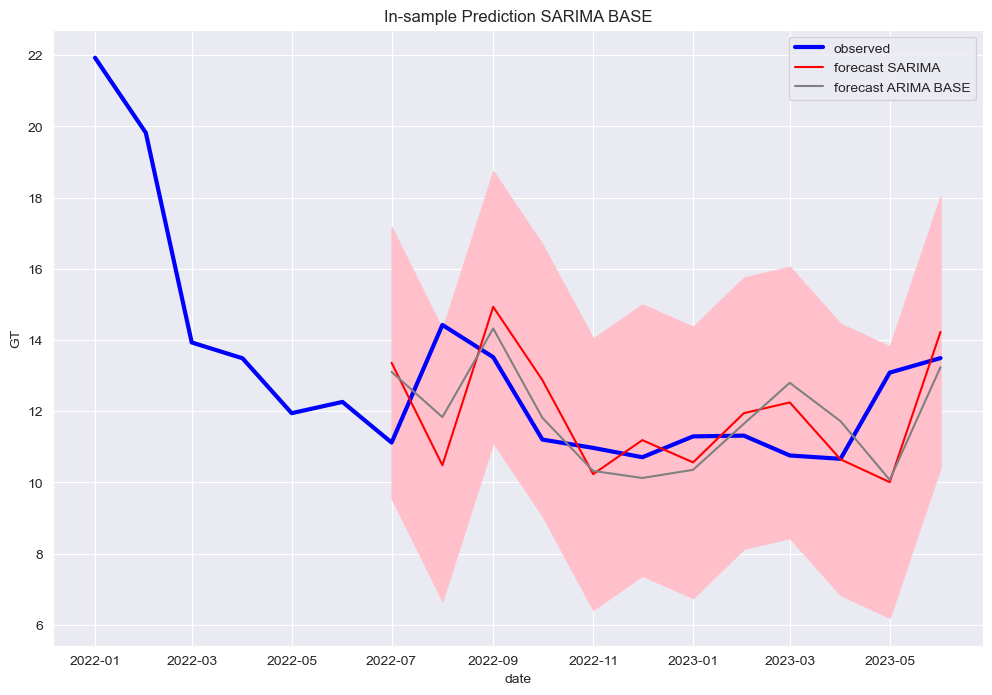

In [86]:
# generate in-sample forecasts, using the last steps of training data

# make predictions for last 25 entries of training data, using one-step ahead
forecast_sarima_base_train = sarima_results_base.get_prediction(start=-12, dynamic=False)

# extract predicted forecasts, in our case by month
mean_forecast = forecast_sarima_base_train.predicted_mean

# get confidence levels of predictions
confidence_intervals = forecast_sarima_base_train.conf_int()

# # select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower GT']
upper_limits = confidence_intervals.loc[:, 'upper GT']

fig, axes = plt.subplots(1,1, figsize=(12,8))
# plot actual/observed
sns.lineplot(df_train['GT']['2022':],
             color='blue',
             label='observed', 
             lw=3,
             ax=axes)

# plot prediction
sns.lineplot(forecast_sarima_base_train.predicted_mean,
             color='red',
             label='forecast SARIMA',
             ax=axes)


# plot prediction
sns.lineplot(forecast_arima_base_train_exog.predicted_mean,
             color='grey',
             label='forecast ARIMA BASE',
             ax=axes)

# shade confidence levels / uncertainty
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('In-sample Prediction SARIMA BASE')
plt.show()

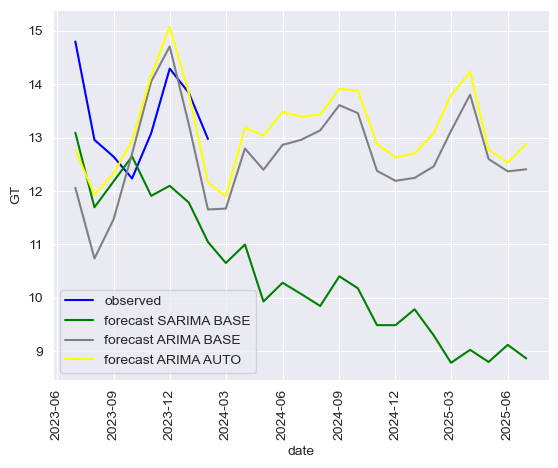

In [130]:
# forcasting out of sample 

start = len(df_train)
end = len(df_train) + 24
forecast_sarima_base_test = sarima_results_base.predict(
    start=start, 
    end=end,
    exog=df_volume_test['volume'][:end],
    dynamic=False)

fig, axes = plt.subplots(1,1)

# plot actual
sns.lineplot(df_test['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(forecast_sarima_base_test,
             color='green',
             label='forecast SARIMA BASE',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test_exog,
             color='grey',
             label='forecast ARIMA BASE',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_results_auto_test,
             color='yellow',
             label='forecast ARIMA AUTO',
             ax=axes)

axes = change_ticker(axes)

plt.show()

Excellent! Time series data collected on a seasonal basis typically have mixed dependence. For example, what happens in June is often related to what happened in May as well as what happened in June of last year.

# Grid Searching for the best parameters

In [88]:
# results of best model
sarima_results_auto = pm.auto_arima(
    df_train['GT'],
    exog=df_train['volume'],
    seasonal=True,
    trace=False,
    n_jobs=-1,
    D=None,
    d=None,
    test='adf',
    m=4,
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,    
    max_p=12,
    max_q=12,
    max_P=5,
    max_Q=5,  
    max_order=24,
    information_criterion='aic',
    error_action='ignore',
    stepwise=False,
    maxiter=10000,
    suppress_warnings=True,
    # enforce_stationarity=False,
    # enforce_invertibility=False,    
    )

In [89]:
print(sarima_results_auto.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2, 3], 4)   Log Likelihood                -225.189
Date:                                   Mon, 18 Mar 2024   AIC                            462.378
Time:                                           18:14:02   BIC                            478.635
Sample:                                       03-01-2014   HQIC                           468.973
                                            - 06-01-2023                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2264      0.194     -1.165      0.244    

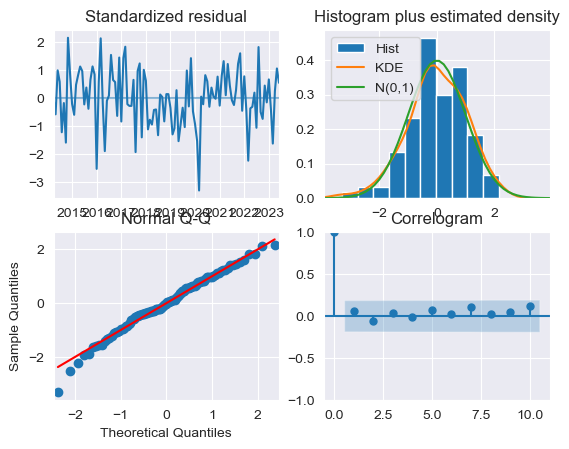

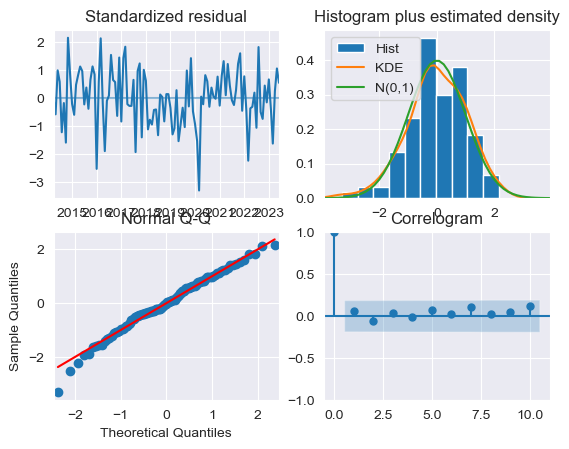

In [90]:
sarima_results_auto.plot_diagnostics()

In [91]:
sarima_model_auto = SARIMAX(
    endog=df_train['GT'], 
    exog=df_train[['volume']],
    order=sarima_results_auto.order, # what happened last x months suggest non-seasonal MA
    seasonal_order=sarima_results_auto.seasonal_order, # what happened last year suggest seasonal RA
    # enforce_stationarity=False,
    # enforce_invertibility=False,
)

sarima_results_auto = sarima_model_auto.fit(disp=False)

print(sarima_results_auto.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                        GT   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2, 3], 4)   Log Likelihood                -224.423
Date:                                   Mon, 18 Mar 2024   AIC                            460.846
Time:                                           18:14:03   BIC                            477.103
Sample:                                       03-01-2014   HQIC                           467.441
                                            - 06-01-2023                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume        -0.0980      0.070     -1.403      0.161    

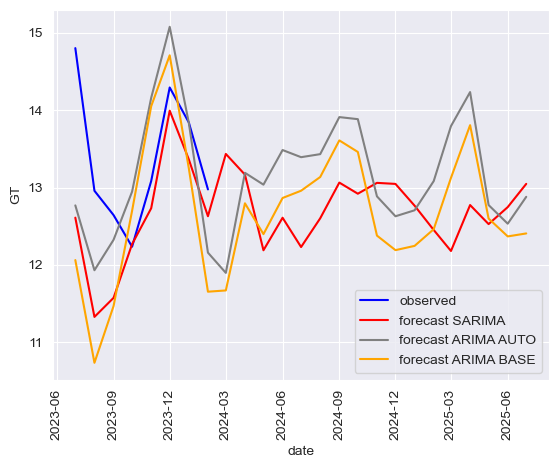

In [92]:
# forcasting out of sample 12 months in future, using one step ahead
start = len(df_train)
end = len(df_train) + 24
sarima_forecast_auto_test = sarima_results_auto.predict(
    start=start, 
    end=end,
    exog=df_volume_test['volume'][:end],
    dynamic=False)

# extract predicted forecasts, in our case by month
# mean_forecast = forecast.predicted_mean

fig, axes = plt.subplots(1,1)

# plot actual
sns.lineplot(df_test['GT'],
             color='blue',
             label='observed', 
             ax=axes)

# plot prediction
sns.lineplot(sarima_forecast_auto_test,
             color='red',
             label='forecast SARIMA',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_results_auto_test,
             color='grey',
             label='forecast ARIMA AUTO',
             ax=axes)

# plot prediction
sns.lineplot(forecast_arima_base_test_exog,
             color='orange',
             label='forecast ARIMA BASE',
             ax=axes)

axes = change_ticker(axes)

plt.show()

In [133]:
# Import joblib
import joblib

# Set model path
arima_model_path = "../models/arima_model.pkl"
volume_model_path = "../models/volume_model.pkl"

# Pickle it
joblib.dump(sarima_results_volume, volume_path)
joblib.dump(arima_results_auto, arima_path)

['../models/arima_model.pkl']

In [94]:
# load back the model
# model_results_object = joblib.load(filename)

# for later - updating the model
# model_results_object.update(df_new)

In [95]:
# Create SARIMA mean forecast
# sarima_pred = results.get_forecast(steps=25)
# sarima_mean = sarima_pred.predicted_mean
# 
# # Plot mean ARIMA and SARIMA predictions and observed
# plt.plot(dates, sarima_mean, label='SARIMA')
# plt.plot(marketstack_ma_month, label='observed')
# plt.legend()
# plt.show()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

# Step x: Prediction

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(14,8))
# marketstack_monthly['2020':'2026']['GT'].plot(ax=ax)
# plot_predict(arima_results, start='2023', end='2026', alpha=None, ax=ax, dynamic=False)
# plot_predict(sarima_results, start='2023', end='2026', alpha=None, ax=ax, dynamic=False)
# plt.show() 

# References

https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/2
https://otexts.com/fpp2/seasonal-arima.html
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Time%20Series%20Forecastings.ipynb
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44